<a href="https://colab.research.google.com/github/hmghaly/ai/blob/main/ai_semantic_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Start

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
cwd='/content/drive/MyDrive/AI_UN' #directory where we keep the data
if not os.path.exists(cwd): os.makedirs(cwd)  #if the directory doesn't exist, create it
os.chdir(cwd) #change current work directory to the directory where we keep the data
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AI_UN


In [2]:
!rm -r code_utils #first delete the code_utils folder, then clone from the codebase (very crude till we figure out using github from colab)
!git clone https://github.com/hmghaly/word_align.git code_utils

Cloning into 'code_utils'...
remote: Enumerating objects: 2303, done.
remote: Counting objects: 100% (463/463), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 2303 (delta 289), reused 455 (delta 283), pack-reused 1840
Receiving objects: 100% (2303/2303), 29.31 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (1131/1131), done.


In [3]:
!pip install sqlitedict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sqlitedict: filename=sqlitedict-2.1.0-py3-none-any.whl size=16863 sha256=76ffd3f119693850447d8954f152c42e09096cf57382d5c42d5c12a9b8953c32
  Stored in directory: /root/.cache/pip/wheels/79/d6/e7/304e0e6cb2221022c26d8161f7c23cd4f259a9e41e8bbcfabd
Successfully built sqlitedict


In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!rm -r GAresolutions
!git clone https://github.com/UNxml/GAresolutions.git GAresolutions

#add security council and ecosoc

rm: cannot remove 'GAresolutions': No such file or directory
Cloning into 'GAresolutions'...
remote: Enumerating objects: 9403, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 9403 (delta 210), reused 246 (delta 183), pack-reused 9108
Receiving objects: 100% (9403/9403), 61.46 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (7487/7487), done.
Updating files: 100% (5484/5484), done.


#Sematic Search
Parsing XML machine readable resolutions and enable making semantic queries into the resolution data

##Main XML processing functions
extract data from XML, convert to JSON and HTML

In [ ]:
from code_utils.web_lib import *
from code_utils.general import *

#data_keys=["docnumber","doctitle","session","docdate","inline","docauthority","keyword","step","analysis","parliamentary"]
data_keys=["docnumber","doctitle","session","docdate","inline","docauthority",
           "keyword","step","voting","count","workflow","classification","docketnumber",
           "docstatus","docproponent","preface","formula","container","authorialnote",
           "paragraph","subheading","preamble"]

def extract_data_items(xml_path): #read xml file, extract relevant data from tag names
  data_list0=[]
  fopen=open(xml_path)
  xml_content=fopen.read()
  fopen.close()
  dom_obj=DOM(xml_content)
  items=list(dom_obj.tag_dict.items())
  for key0,val0 in items:
    if key0=="": continue
    if key0.startswith("text_node"): continue
    if key0.startswith("akomantoso"): continue
    if key0.startswith('!--'): continue
    tag_name=key0.rstrip("0123456789_")
    attrs0=val0.attrs
    inner0=val0.inner_html
    if tag_name in ["voting","preamble"]: inner0=[""]
    elif tag_name=="count":
      count_dom_obj=DOM(inner0)
      count_tag_dict_items=list(count_dom_obj.tag_dict.items())
      count_tag_dict_items.sort()
      count_tag_dict_items=[b.inner_html for a,b in count_tag_dict_items if a.startswith("organization")]
      inner0=count_tag_dict_items
    else:
      inner0=[remove_tags(inner0).strip()]
    if tag_name in data_keys:
      data_list0.append((tag_name,attrs0,inner0))
    else:
      pass
      #print("Not included in keys:",tag_name,attrs0,inner0[:100])
  return data_list0

def text2id(text): #create an ID from text, to standardize titles and other strings
  text=re.sub("\W+","_",text.lower())
  text=text.strip("_")
  return text


def xml2json(xml_path,json_path): #save the extracted data list (tag_name0,tag_attrs0,tag_content0)
  data_list0=extract_data_items(xml_path)
  out_fopen=open(json_path,"w")
  data_json=json.dump(data_list0,out_fopen)
  out_fopen.close()


def dict2html(dict0): #convert attrs dict (or any dict) to html
  html0=""
  for a,b in dict0.items():
    line0='<b>%s</b>: %s<br>'%(a,b)
    html0+=line0
  return html0

def xml2html(xml_fpath,out_html_fpath,html_template_fpath): #extract relevant info from xml, tabulate them in html table, populate it into html template
  data_list1=extract_data_items(xml_fpath)
  table_content0=""
  for i0,tag_item0 in enumerate(data_list1):
    tag_name0,tag_attrs0,tag_content0=tag_item0
    table_class="table-light"
    if i0%2!=0: table_class="table-dark text-dark"
    if tag_name0 in ['voting',"doctitle","workflow","classification"]: table_class="table-primary"
    if tag_name0 in ["preamble","authorialnote","docdate"]: table_class="table-info"
    if tag_attrs0.get("refersTo")=='inFavour': table_class="table-success"
    if tag_attrs0.get("refersTo")=='against': table_class="table-danger"
    if tag_attrs0.get("refersTo")=='abstaining': table_class="table-warning"
    attrs_html0=dict2html(tag_attrs0)
    content_html="; ".join(tag_content0)
    cur_tr0='<tr class="%s"><td>%s</td><td>%s</td><td>%s</td></tr>'%(table_class,tag_name0,attrs_html0,content_html)
    table_content0+=cur_tr0
  template_fopen=open(html_template_fpath)
  template_content=template_fopen.read()
  template_fopen.close()
  template_dom_obj=DOM(template_content)
  repl_dict={"#data_display_table_body":table_content0}
  out_html=template_dom_obj.replace(repl_dict)

  out_fopen=open(out_html_fpath,"w")
  out_fopen.write(out_html)
  out_fopen.close()


countries_with_and=["Antigua and Barbuda","Saint Kitts and Nevis","Saint Vincent and the Grenadines",
                    "Sao Tome and Principe","Trinidad and Tobago", "Bosnia and Herzegovina",
                    "United Kingdom of Great Britain and Northern Ireland"]
def split_country_str(country_str): #split strings of county names, by commas and final "and", while avoidng splitting names which already have "and" in them
  #print("Hello!")
  repl_dict={}
  country_str=re.sub("\s+"," ",country_str)
  country_str=country_str.lower()
  country_str=country_str.replace("the representative of","")
  for i0,c0 in enumerate(countries_with_and):
    c0=re.sub("\s+"," ",c0)
    #print(">>>",c0, c0.lower() in country_str)
    if c0.lower() in country_str:

      #repl_key0=c0.lower().replace(" ","_")
      repl_key0="COUNTRY_%s"%i0
      repl_dict[repl_key0]=c0
      country_str=country_str.replace(c0.lower(),repl_key0)
  country_str=country_str.replace(" (in ",", (in ")
  country_str=country_str.replace(" (on ",", (on ")

  country_str=re.sub(r'\band\b',",",country_str)
  #country_str=re.sub(r' and ',",",country_str)
  for a,b in repl_dict.items():
    country_str=country_str.replace(a,b)
  country_str_split=country_str.split(",")
  countries0=[v.strip().upper() for v in country_str_split if v.strip()]
  return countries0


def extract_info(json_fpath): #process tabulated xml data (each table has 3 elements: tag name, tag attributes, and tag content - always a list of items)
  cur_info_dict={}
  json_fopen=open(json_fpath)
  json_data=json.load(json_fopen)
  json_fopen.close()
  sdgs,agenda_items,subjects,sponsors_all,sponsors_intial=[],[],[],[],[]
  sponsors_additional=[]
  agenda_items_full=[]
  for item0 in json_data:
    #print(item0)
    tag_name0,tag_attrs0,tag_content0=item0
    #if tag_name0=="docnumber": print(item0)
    if tag_name0=="docnumber" and tag_attrs0.get("refersTo")=='#symbol': cur_info_dict["symbol"]=tag_content0[0]
    elif tag_name0=="docnumber": cur_info_dict["number"]=tag_content0[0]
    elif tag_name0=="doctitle":
      cur_info_dict["title"]=tag_content0[0]
      cur_info_dict["title_id"]=text2id(tag_content0[0])
    elif tag_name0=="session": cur_info_dict["session"]=tag_attrs0.get("value","")
    elif tag_name0=="inline" and tag_attrs0.get("name")=='adoptionMeeting':
      #print(tag_attrs0)
      cur_info_dict["meeting"]=tag_content0[0]
    elif tag_name0=="docdate" and tag_attrs0.get("refersTo")=='#adoptionDate': cur_info_dict["adoption_date"]=tag_attrs0.get("date","")
    elif tag_name0=="docproponent": cur_info_dict["committee"]=tag_attrs0.get("refersTo","")
    elif tag_name0=="inline" and tag_attrs0.get("name")=='originating document': cur_info_dict["originating_document"]=tag_content0[0]
    elif tag_name0=="step" and tag_attrs0.get("outcome")=='draftResolution':
      cur_info_dict["draft_resolution_date"]=tag_attrs0.get("date","")
      cur_info_dict["draft_resolution_symbol"]=tag_attrs0.get("as","")
      sponsors_intial=split_country_str(tag_attrs0.get("by",""))
      sponsors_all.extend(sponsors_intial)
      cur_info_dict["sponsors_intial"]=sponsors_intial
    elif tag_name0=="step" and tag_attrs0.get("outcome")=='draftResolutionAdditionalSponsors':
      sponsors_additional=split_country_str(tag_attrs0.get("by",""))
      # sponsors_additional_raw=tag_attrs0.get("by","")
      # cur_info_dict["sponsors_additional_raw"]=sponsors_additional_raw
      sponsors_all.extend(sponsors_additional)
      cur_info_dict["sponsors_additional"]=sponsors_additional
    elif tag_name0=="step" and tag_attrs0.get("outcome")=='recommendedForAdoption':
      pass
      #cur_info_dict["recommendedForAdoption"]=tag_attrs0.get("by","")
    elif tag_name0=="step" and tag_attrs0.get("outcome")=='adopted':
      #cur_info_dict["step_adoption_date"]=tag_attrs0.get("date","")
      cur_info_dict["meeting_pv"]=tag_attrs0.get("as","")
      #cur_info_dict["recommendedForAdoption"]=tag_attrs0.get("by","")
    elif tag_name0=="keyword":
      if tag_attrs0.get("dictionary","")=='SDGO':
        sdgs.append(tag_attrs0.get("value",""))
      elif tag_attrs0.get("refersTo","")=='agenda':
        agenda_item_val=tag_attrs0.get("value","")
        agenda_item_text=tag_attrs0.get("showAs","")
        agenda_item_dictionary=tag_attrs0.get("dictionary","")
        combined_item_val="%s|%s"%(agenda_item_dictionary,agenda_item_val)
        #agenda_items.append((combined_item_val,agenda_item_text))
        agenda_items.append(combined_item_val)
        agenda_items_full.append("%s = %s"%(combined_item_val,agenda_item_text))
      else:
        subjects.append(tag_attrs0.get("showAs",""))
    elif tag_name0=="voting": cur_info_dict["voting_outcome"]=tag_attrs0.get("outcome","")
    elif tag_name0=="count":
      refersTo=tag_attrs0.get("refersTo","")
      if refersTo=="inFavour":
        cur_info_dict["vote_for_count"]=tag_attrs0.get("value","")
        cur_info_dict["vote_for"]=sorted(tag_content0)
      elif refersTo=="against":
        cur_info_dict["vote_against_count"]=tag_attrs0.get("value","")
        cur_info_dict["vote_against"]=sorted(tag_content0)
      elif refersTo=="abstaining":
        cur_info_dict["vote_abstaining_count"]=tag_attrs0.get("value","")
        cur_info_dict["vote_abstaining"]=sorted(tag_content0)

      #cur_info_dict["voting_outcome"]=tag_attrs0.get("outcome","")
      #print(item0)

    #elif tag_name0=="step" and tag_attrs0.get("outcome")=='recommendedForAdoption': cur_info_dict["Report paragraph"]=tag_attrs0.get("by","")
  cur_info_dict["agenda_items"]=agenda_items
  cur_info_dict["agenda_items_full"]=agenda_items_full
  try: cur_info_dict["sdgs"]=sorted(sdgs,key=lambda x:float(x))
  except: cur_info_dict["sdgs"]=sorted(sdgs)
  cur_info_dict["subjects"]=sorted(list(set(subjects)))
  cur_info_dict["sponsors_all"]=sorted(sponsors_all)
  return cur_info_dict






#xml_filename='GAresolutions/77session/English/A_RES_77_100-2228244E.xml'
#xml_filename='GAresolutions/77session/English/A_RES_77_104-2228250E.xml'
xml_filename0='GAresolutions/77session/English/A_RES_77_149-2228534E.xml'
template_fpath0="templates/machine_readable_table_template.html"
out_html_path0="output/semantic-initial2.html"
out_json_path0="output/semantic-initial0.json"

xml2html(xml_filename0,out_html_path0,template_fpath0)

xml2json(xml_filename0,out_json_path0)
final_info_dict=extract_info(out_json_path0)

for a,b in final_info_dict.items():
  print(a,b)

# data_list1=extract_data_items(xml_filename)
# table_content0=""
# for i0,tag_item0 in enumerate(data_list1):
#   tag_name0,tag_attrs0,tag_content0=tag_item0
#   table_class="table-light"
#   if i0%2!=0: table_class="table-dark text-dark"

#   if tag_name0 in ['voting',"doctitle","workflow","classification"]: table_class="table-primary"
#   if tag_name0 in ["preamble","authorialnote","docdate"]: table_class="table-info"
#   if tag_attrs0.get("refersTo")=='inFavour': table_class="table-success"
#   if tag_attrs0.get("refersTo")=='against': table_class="table-danger"
#   if tag_attrs0.get("refersTo")=='abstaining': table_class="table-warning"
#   attrs_html0=dict2html(tag_attrs0)
#   content_html="; ".join(tag_content0)
#   cur_tr0='<tr class="%s"><td>%s</td><td>%s</td><td>%s</td></tr>'%(table_class,tag_name0,attrs_html0,content_html)
#   table_content0+=cur_tr0



# template_fpath="templates/machine_readable_table_template.html"
# template_fopen=open(template_fpath)
# template_content=template_fopen.read()
# template_fopen.close()
# template_dom_obj=DOM(template_content)
# repl_dict={"#data_display_table_body":table_content0}
# out_html=template_dom_obj.replace(repl_dict)

# out_fopen=open("output/semantic-initial.html","w")
# out_fopen.write(out_html)
# out_fopen.close()


# fopen=open(xml_filename)
# xml_content=fopen.read()
# fopen.close()
# dom_obj=DOM(xml_content)

# items=list(dom_obj.tag_dict.items())
# for a,b in items:
#   if a=="": continue
#   if a.startswith("text_node"): continue
#   if a.startswith("akomantoso"): continue
#   if a.startswith('!--'): continue
#   print(a,b.attrs)
#   print([b.inner_html[:200]])

#docnumber_0, doctitle_0,
#session_0 {'refersTo': '#generalAssembly', 'value': '77', 'eId': 'coverPage_1__session_1'}
#docdate_0 {'date': '2022-12-19', 'class': 'rightSmall', 'refersTo': '#dateOfIssuance'}
#inline_0 {'title': '77', 'name': 'agenda item'}
#docauthority_2 {'refersTo': '#issuingBody', 'class': 'rightBig'} ['General Assembly']
#docauthority_0 {'refersTo': '#publisher'} ['United Nations']
#keyword_74 {'refersTo': 'agenda', 'value': '77', 'showAs': 'Report of the International Law Commission on the work of its 73rd session.', 'shortForm': 'INTERNATIONAL LAW', 'dictionary': 'A/77/251'}
#keyword_68 {'value': 'ARMED CONFLICTS', 'showAs': 'ARMED CONFLICTS', 'dictionary': 'UNBIS Thesaurus'}
#keyword_62 {'value': 'full_employment', 'href': 'http://metadata.un.org/thesaurus/1002563', 'showAs': 'full_employment', 'dictionary': 'UNBIS'}
#classification_4 {'source': 'http://metadata.un.org/sdg'}
#workflow_0 {'source': '#un'}
#step_0 {'date': '2022-10-27', 'outcome': 'draftResolution', 'as': 'A/C.6/77/L.8', 'by': 'the representative of Thailand, on behalf of the Bureau'}
#step_1 {'date': '0001-01-01', 'outcome': 'draftResolutionAdditionalSponsors'}
#step_2 {'date': '0001-01-01', 'outcome': 'recommendedForAdoption', 'as': 'A/77/413', 'by': '" refersTo='}
#step_3 {'date': '2022-12-07', 'outcome': 'adopted', 'as': 'A/77/PV.47'}
#analysis_0 {'source': '#un'}
#parliamentary_0 {}
#voting_0 {'outcome': 'adoptedWithoutVote'} voting_0 {'outcome': 'adoptedRecordedVote'}
#count_0 {'value': '124', 'refersTo': 'inFavour'}
#count_2 {'value': '3', 'refersTo': 'against'}
#count_4 {'value': '42', 'refersTo': 'abstaining'}






draft_resolution_date 2022-06-15
draft_resolution_symbol A/AC.109/2022/L.9
sponsors_intial ['SUBMITTED BY THE SPECIAL COMMITTEE ON THE SITUATION WITH REGARD TO THE IMPLEMENTATION OF THE DECLARATION ON THE GRANTING OF INDEPENDENCE TO COLONIAL COUNTRIES', 'PEOPLES']
sponsors_additional []
meeting_pv A/77/PV.52
voting_outcome adoptedRecordedVote
vote_for_count 124
vote_for ['AFGHANISTAN', 'ALGERIA', 'ANGOLA', 'ANTIGUA AND BARBUDA', 'ARGENTINA', 'ARMENIA', 'AZERBAIJAN', 'BAHAMAS', 'BAHRAIN', 'BANGLADESH', 'BARBADOS', 'BELARUS', 'BELIZE', 'BENIN', 'BHUTAN', 'BOLIVIA (PLURINATIONAL STATE OF)', 'BOSNIA AND HERZEGOVINA', 'BOTSWANA', 'BRAZIL', 'BRUNEI DARUSSALAM', 'BURKINA FASO', 'BURUNDI', 'CAMBODIA', 'CAMEROON', 'CHAD', 'CHILE', 'CHINA', 'COLOMBIA', 'COSTA RICA', "COTE D'IVOIRE", 'CUBA', 'CYPRUS', "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA", 'DOMINICAN REPUBLIC', 'ECUADOR', 'EGYPT', 'EL SALVADOR', 'EQUATORIAL GUINEA', 'ERITREA', 'ETHIOPIA', 'FIJI', 'GABON', 'GAMBIA', 'GHANA', 'GREECE', 'GRENADA',

##Now processing all resolutions -
Convert all resolutions (English) to JSON format for easier processing - only once or every time we update the extraction function

In [ ]:
import json
from code_utils.general import *
#cur_dir='GAresolutions/77session/English'
cur_dir='GAresolutions'
output_dir="output/res_json"
if not os.path.exists(output_dir): os.makedirs(output_dir)
files0=get_dir_files(cur_dir,"xml")

for fpath0 in files0:
  if not "English" in fpath0: continue
  fname0=os.path.split(fpath0)[-1]
  json_fname=fname0.replace(".xml",".json")
  json_fpath=os.path.join(output_dir,json_fname)
  if os.path.exists(json_fpath): continue

  print(fpath0,fname0)
  data_list0=extract_data_items(fpath0)
  out_fopen=open(json_fpath,"w")
  data_json=json.dump(data_list0,out_fopen)
  out_fopen.close()

#extract_data_items
# xml_filename='GAresolutions/77session/English/A_RES_77_149-2228534E.xml'
# files=""

GAresolutions/75session/English/75_100_E.xml 75_100_E.xml
GAresolutions/75session/English/75_101A-B_E.xml 75_101A-B_E.xml
GAresolutions/75session/English/75_102_E.xml 75_102_E.xml
GAresolutions/75session/English/75_103_E.xml 75_103_E.xml
GAresolutions/75session/English/75_104_E.xml 75_104_E.xml
GAresolutions/75session/English/75_105_E.xml 75_105_E.xml
GAresolutions/75session/English/75_106_E.xml 75_106_E.xml
GAresolutions/75session/English/75_107_E.xml 75_107_E.xml
GAresolutions/75session/English/75_108_E.xml 75_108_E.xml
GAresolutions/75session/English/75_109_E.xml 75_109_E.xml
GAresolutions/75session/English/75_10_E.xml 75_10_E.xml
GAresolutions/75session/English/75_110_E.xml 75_110_E.xml
GAresolutions/75session/English/75_111_E.xml 75_111_E.xml
GAresolutions/75session/English/75_112_E.xml 75_112_E.xml
GAresolutions/75session/English/75_113_E.xml 75_113_E.xml
GAresolutions/75session/English/75_114_E.xml 75_114_E.xml
GAresolutions/75session/English/75_115_E.xml 75_115_E.xml
GAresoluti

In [ ]:
country_str1='Andorra, Australia, Bosnia and Herzegovina, Bulgaria, Croatia, Dominican Republic, Finland, Hungary, Japan, Kuwait, Latvia, Liechtenstein, Lithuania, Monaco, Mongolia, Montenegro, New Zealand, North Macedonia, Palau, Poland, Portugal, Republic of Korea, Romania, San Marino, Saudi Arabia, Slovakia, Switzerland, Tajikistan, Thailand, Türkiye, Ukraine and Vanuatu'
#"Bosnia and Herzegovina".lower() in country_str1.lower()
split_country_str(country_str1)

['ANDORRA',
 'AUSTRALIA',
 'BOSNIA AND HERZEGOVINA',
 'BULGARIA',
 'CROATIA',
 'DOMINICAN REPUBLIC',
 'FINLAND',
 'HUNGARY',
 'JAPAN',
 'KUWAIT',
 'LATVIA',
 'LIECHTENSTEIN',
 'LITHUANIA',
 'MONACO',
 'MONGOLIA',
 'MONTENEGRO',
 'NEW ZEALAND',
 'NORTH MACEDONIA',
 'PALAU',
 'POLAND',
 'PORTUGAL',
 'REPUBLIC OF KOREA',
 'ROMANIA',
 'SAN MARINO',
 'SAUDI ARABIA',
 'SLOVAKIA',
 'SWITZERLAND',
 'TAJIKISTAN',
 'THAILAND',
 'TÜRKIYE',
 'UKRAINE',
 'VANUATU']

In [ ]:
# import json, re
# from itertools import groupby
# from code_utils.general import *

# countries_with_and=["Antigua and Barbuda","Saint Kitts and Nevis","Saint Vincent and the Grenadines",
#                     "Sao Tome and Principe","Trinidad and Tobago","United Kingdom of Great Britain and Northern Ireland"]
# def split_country_str(country_str):
#   repl_dict={}
#   country_str=country_str.lower()
#   country_str=country_str.replace("the representative of","")
#   for i0,c0 in enumerate(countries_with_and):
#     if c0.lower() in country_str:
#       #repl_key0=c0.lower().replace(" ","_")
#       repl_key0="COUNTRY_%s"%i0
#       repl_dict[repl_key0]=c0
#       country_str=country_str.replace(c0.lower(),repl_key0)
#   country_str=country_str.replace(" (in ",", (in ")
#   country_str=country_str.replace(" (on ",", (on ")

#   country_str=re.sub(r'\band\b',",",country_str)
#   #country_str=re.sub(r' and ',",",country_str)
#   for a,b in repl_dict.items():
#     country_str=country_str.replace(a,b)
#   country_str_split=country_str.split(",")
#   countries0=[v.strip().upper() for v in country_str_split if v.strip()]
#   return countries0


# def extract_info(json_fpath):
#   cur_info_dict={}
#   json_fopen=open(json_fpath)
#   json_data=json.load(json_fopen)
#   json_fopen.close()
#   sdgs,agenda_items,subjects,sponsors_all,sponsors_intial=[],[],[],[],[]
#   agenda_items_with_text=[]
#   for item0 in json_data:
#     #print(item0)
#     tag_name0,tag_attrs0,tag_content0=item0
#     #if tag_name0=="docnumber": print(item0)
#     if tag_name0=="docnumber" and tag_attrs0.get("refersTo")=='#symbol': cur_info_dict["symbol"]=tag_content0[0]
#     elif tag_name0=="docnumber": cur_info_dict["number"]=tag_content0[0]
#     elif tag_name0=="doctitle": cur_info_dict["title"]=tag_content0[0]
#     elif tag_name0=="session": cur_info_dict["session"]=tag_attrs0.get("value","")
#     elif tag_name0=="inline" and tag_attrs0.get("name")=='adoptionMeeting':
#       #print(tag_attrs0)
#       cur_info_dict["meeting"]=tag_content0[0]
#     elif tag_name0=="docdate" and tag_attrs0.get("refersTo")=='#adoptionDate': cur_info_dict["adoption_date"]=tag_attrs0.get("date","")
#     elif tag_name0=="docproponent": cur_info_dict["committee"]=tag_attrs0.get("refersTo","")
#     elif tag_name0=="inline" and tag_attrs0.get("name")=='originating document': cur_info_dict["originating_document"]=tag_content0[0]
#     elif tag_name0=="step" and tag_attrs0.get("outcome")=='draftResolution':
#       cur_info_dict["draft_resolution_date"]=tag_attrs0.get("date","")
#       cur_info_dict["draft_resolution_symbol"]=tag_attrs0.get("as","")
#       sponsors_intial=split_country_str(tag_attrs0.get("by",""))
#       sponsors_all.extend(sponsors_intial)
#       cur_info_dict["sponsors_intial"]=sponsors_intial
#     elif tag_name0=="step" and tag_attrs0.get("outcome")=='draftResolutionAdditionalSponsors':
#       sponsors_additional=split_country_str(tag_attrs0.get("by",""))
#       sponsors_all.extend(sponsors_additional)
#       cur_info_dict["sponsors_additional"]=sponsors_additional
#     elif tag_name0=="step" and tag_attrs0.get("outcome")=='recommendedForAdoption':
#       cur_info_dict["recommendedForAdoption"]=tag_attrs0.get("by","")
#     elif tag_name0=="step" and tag_attrs0.get("outcome")=='adopted':
#       cur_info_dict["step_adoption_date"]=tag_attrs0.get("date","")
#       cur_info_dict["meeting_pv"]=tag_attrs0.get("as","")
#       #cur_info_dict["recommendedForAdoption"]=tag_attrs0.get("by","")
#     elif tag_name0=="keyword":
#       if tag_attrs0.get("dictionary","")=='SDGO':
#         sdgs.append(tag_attrs0.get("value",""))
#       elif tag_attrs0.get("refersTo","")=='agenda':
#         agenda_item_val=tag_attrs0.get("value","")
#         agenda_item_text=tag_attrs0.get("showAs","")
#         agenda_item_dictionary=tag_attrs0.get("dictionary","")
#         combined_item_val="%s|%s"%(agenda_item_dictionary,agenda_item_val)
#         agenda_items.append(combined_item_val)
#         #agenda_items.append((combined_item_val,agenda_item_text))
#       else:
#         subjects.append(tag_attrs0.get("showAs",""))
#     elif tag_name0=="voting": cur_info_dict["voting_outcome"]=tag_attrs0.get("outcome","")
#     elif tag_name0=="count":
#       refersTo=tag_attrs0.get("refersTo","")
#       if refersTo=="inFavour":
#         cur_info_dict["vote_for_count"]=tag_attrs0.get("value","")
#         cur_info_dict["vote_for"]=sorted(tag_content0)
#       elif refersTo=="against":
#         cur_info_dict["vote_against_count"]=tag_attrs0.get("value","")
#         cur_info_dict["vote_against"]=sorted(tag_content0)
#       elif refersTo=="abstaining":
#         cur_info_dict["vote_abstaining_count"]=tag_attrs0.get("value","")
#         cur_info_dict["vote_abstaining"]=sorted(tag_content0)

#       #cur_info_dict["voting_outcome"]=tag_attrs0.get("outcome","")
#       #print(item0)

#     #elif tag_name0=="step" and tag_attrs0.get("outcome")=='recommendedForAdoption': cur_info_dict["Report paragraph"]=tag_attrs0.get("by","")
#   cur_info_dict["agenda_items"]=agenda_items
#   try:cur_info_dict["sdgs"]=sorted(sdgs,key=lambda x:float(x))
#   except: cur_info_dict["sdgs"]=sorted(sdgs)
#   cur_info_dict["subjects"]=sorted(list(set(subjects)))
#   cur_info_dict["sponsors_all"]=sorted(sponsors_all)
#   return cur_info_dict

# file_i=915


# output_dir="output/res_json"
# json_files=get_dir_files(output_dir)
# cur_json_fpath=json_files[file_i]
# print(len(json_files))
# out_dict0=extract_info(cur_json_fpath)
# info_items=list(out_dict0.items())
# info_items.sort()
# for a,b in info_items:
#   print(a,"=", b)

916
adoption_date = 2022-10-12
agenda_items = ['A/ES-11/2|5']
committee = #noMainCommittee
draft_resolution_date = 2022-10-07
draft_resolution_symbol = A/ES-11/L.5
meeting = 14th plenary meeting
meeting_pv = A/ES-11/PV.14
number = ES-11/4.
originating_document = A/ES-11/L.5
recommendedForAdoption = 
sdgs = ['1', '4', '10', '15', '16']
session = 11
sponsors_additional = []
sponsors_all = ['ALBANIA', 'AUSTRALIA', 'AUSTRIA', 'BELGIUM', 'BULGARIA', 'CANADA', 'CROATIA', 'CYPRUS', 'CZECHIA', 'DENMARK', 'ESTONIA', 'FINLAND', 'FRANCE', 'GEORGIA', 'GERMANY', 'GREECE', 'GUATEMALA', 'HUNGARY', 'ICELAND', 'IRELAND', 'ITALY', 'JAPAN', 'LATVIA', 'LIBERIA', 'LIECHTENSTEIN', 'LITHUANIA', 'LUXEMBOURG', 'MALTA', 'MONTENEGRO', 'NETHERLANDS', 'NORWAY', 'PALAU', 'POLAND', 'PORTUGAL', 'REPUBLIC OF KOREA', 'REPUBLIC OF MOLDOVA', 'ROMANIA', 'SLOVAKIA', 'SLOVENIA', 'SPAIN', 'SWEDEN', 'TRINIDAD AND TOBAGO', 'TÜRKIYE', 'UKRAINE']
sponsors_intial = ['ALBANIA', 'AUSTRALIA', 'AUSTRIA', 'BELGIUM', 'BULGARIA', 'CANAD

In [ ]:
a='ANTIGUA AND BARBUDA'
a.lower()

'antigua and barbuda'

##Indexing data for resolutions

In [ ]:
import json
from itertools import groupby
from code_utils.general import *
from code_utils.sqld_utils import *
#sqld

output_dir="output/res_json"
json_files=get_dir_files(output_dir)
global_info_dict={}
fwd_index=[]
for file_i,fpath0 in enumerate(json_files):
  if file_i%50==0: print(file_i)
  json_info_dict=extract_info(fpath0)
  global_info_dict[fpath0]=json_info_dict
  items0=sorted(list(json_info_dict.items()))
  for key0,val0 in items0:
    if type(val0) is list:
      for v0 in val0: fwd_index.append((key0,v0,fpath0))
    else: fwd_index.append((key0,val0,fpath0))
    #fwd_index.append(())
  #   print(key0,":", val0)
  # print("-----")

# fwd_index.sort()
# for a in fwd_index:
#   print(a)

fwd_index.sort()
final_inv_index_dict={}
grouped_by_main=[(key,[v[1:] for v in list(group)]) for key,group in groupby(fwd_index,lambda x:x[0])]
for key0,grp0 in grouped_by_main:
  grp0.sort()
  grouped_by_seccondary=[(key,[v[1] for v in list(group)]) for key,group in groupby(grp0,lambda x:x[0])]
  grouped_by_seccondary_dict=dict(iter(grouped_by_seccondary))
  final_inv_index_dict[key0]=grouped_by_seccondary_dict

print("json_files",len(json_files))
available_query_keys=sorted(list(final_inv_index_dict.keys()))
print("available query keys:")
print(available_query_keys)
global_info_path="gloabl_ga_res_info.sqld"
dict2sqld(global_info_dict,global_info_path)
print("saved info dict:", global_info_path)

ga_index_path="ga_index.sqld"
dict2sqld(final_inv_index_dict,ga_index_path)
print("saved index dict:", ga_index_path)



0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
json_files 916
available query keys:
['adoption_date', 'agenda_items', 'agenda_items_full', 'committee', 'draft_resolution_date', 'draft_resolution_symbol', 'meeting', 'meeting_pv', 'number', 'originating_document', 'sdgs', 'session', 'sponsors_additional', 'sponsors_all', 'sponsors_intial', 'subjects', 'symbol', 'title', 'title_id', 'vote_abstaining', 'vote_abstaining_count', 'vote_against', 'vote_against_count', 'vote_for', 'vote_for_count', 'voting_outcome']
saved info dict: gloabl_ga_res_info.sqld
saved index dict: ga_index.sqld


##Further extracting info from indexes
###Get all countries, subjects and agenda

In [ ]:
import json
from itertools import groupby
from code_utils.general import *
from code_utils.sqld_utils import *



ga_index_path="ga_index.sqld"
sqld_open=open_sqld(ga_index_path)
vote_for_dict=sqld_open["vote_for"]
vote_against_dict=sqld_open["vote_against"]
vote_abstaining_dict=sqld_open["vote_abstaining"]
all_countries=list(vote_for_dict.keys())+list(vote_against_dict.keys())+list(vote_abstaining_dict.keys())
all_countries=sorted(list(set(all_countries)))

subject_dict=sqld_open["subjects"]
all_subjects=list(subject_dict.keys()) #sorted()
all_subjects=[unescape(v) for v in all_subjects]
all_subjects=sorted(list(set(all_subjects)))


agenda_items_full_dict=sqld_open["agenda_items_full"]
agenda_items_keys=sorted(list(agenda_items_full_dict.keys()))

print("agenda_items_keys",len(agenda_items_keys))
list_agenda_text_keys_item_numbers=[]
list_agenda_item_texts=[]
for ag0 in agenda_items_keys:
  split0=[v.strip() for v in ag0.split("=")]
  if len(split0)!=2: continue
  agenda_item_id,agenda_item_text=split0
  agenda_item_text_id_key=str2key(agenda_item_text)
  list_agenda_text_keys_item_numbers.append((agenda_item_text_id_key,agenda_item_id))
  list_agenda_item_texts.append(agenda_item_text)
  #print(split0,agenda_item_text_id_key)
# print("all_subjects",len(all_subjects))
# for a in all_subjects[:50]: print(a)

all_keys=list(sqld_open.keys())
for key0 in all_keys: print(key0)

sqld_open.close()

agenda_tracking_dict=group_list(list_agenda_text_keys_item_numbers)
list_agenda_item_texts=sorted(list(set(list_agenda_item_texts)))
print("list_agenda_item_texts",len(list_agenda_item_texts))
for a in list_agenda_item_texts[:100]:
  print(a)
# for a,b in agenda_tracking_dict.items():
#   print(a,b)

query_support_dict={}
query_support_dict["countries"]=all_countries
query_support_dict["subjects"]=all_subjects
query_support_dict["agenda_items_text"]=list_agenda_item_texts
query_support_dict["agenda_items_tracking"]=agenda_tracking_dict


query_support_path="query_support.sqld"
dict2sqld(query_support_dict,query_support_path)
print("saved query_support_dict:", query_support_path)

# list_agenda_text_keys_item_numbers.sort()
# for a in list_agenda_text_keys_item_numbers[:100]:
#   print(a)
# for ac in all_countries:
#   print(ac)

agenda_items_keys 538
recommendedForAdoption
step_adoption_date
adoption_date
agenda_items
agenda_items_full
committee
draft_resolution_date
draft_resolution_symbol
meeting
meeting_pv
number
originating_document
sdgs
session
sponsors_additional
sponsors_all
sponsors_intial
subjects
symbol
title
title_id
vote_abstaining
vote_abstaining_count
vote_against
vote_against_count
vote_for
vote_for_count
voting_outcome
list_agenda_item_texts 479
(32ND SPECIAL SESS. : 2021 : NEW YORK)--DECLARATION
2030 AGENDA--PROGRAMME IMPLEMENTATION
ADMINISTRATION OF JUSTICE
ADMINISTRATION OF JUSTICE--HUMAN RIGHTS
AFRICA--DEVELOPMENT
AFRICA--SUSTAINABLE DEVELOPMENT--PARTNERSHIP
AFRICAN UNION MISSION IN SOMALIA--FINANCING
AGEING PERSONS
ALBINISM
AMERICAN SAMOA QUESTION
ANGUILLA QUESTION
ARMED CONFLICTS PREVENTION
ARMS RACE--OUTER SPACE
ARMS TRANSFERS--INTERNATIONAL INSTRUMENTS
AU-UN HYBRID OPERATION IN DARFUR--FINANCING
Administration of justice at the United Nations.
Administrative and budgetary aspects of the

##Create word vectors for subjects and agenda items

In [ ]:
import gensim
import gensim.downloader as api

# google_model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use
# print("imported google model")
en_wv_path='un_wv.model'
wv_model = gensim.models.Word2Vec.load(en_wv_path)
print("imported word vector")

imported word vector


In [ ]:
wv_model.wv.most_similar("decide")

[('determine', 0.5730881690979004),
 ('choose', 0.5626469254493713),
 ('retain', 0.5538421869277954),
 ('proceed', 0.5520201921463013),
 ('authorize', 0.5464128255844116),
 ('advise', 0.5461869239807129),
 ('revert', 0.5428701639175415),
 ('approve', 0.5415611863136292),
 ('notify', 0.5359577536582947),
 ('insist', 0.5341869592666626)]

In [ ]:
topic0="Egypt"
words=re.findall("\w+",topic0)
topic_vector0=wv_model.wv.get_mean_vector(words)
print(topic_vector0)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
def text_split(text,excluded_words=[]):
  text_words=re.findall("\w+",text.lower())
  text_words=[v for v in text_words if not v in excluded_words]
  return text_words
cur_excluded=["the","of","for", "in","on","at","to","from","and"]
query_support_path="query_support.sqld"
sqld_fopen=open_sqld(query_support_path)
subject_list=sqld_fopen["subjects"]
print("subject_list",len(subject_list))
subj_vec_list=[]
for subj0 in subject_list:
  subj_words=text_split(subj0,cur_excluded) #re.findall("\w+",subj0.lower())
  subj_vector0=wv_model.wv.get_mean_vector(subj_words)
  if sum(subj_vector0)==0: continue
  subj_vec_list.append((subj0,subj_vector0))

  #print(subj0,sum(subj_vector0))
#print("saved query_support_dict:", query_support_path)
sqld_fopen.close()

subject_list 1484


###test with a topic query

In [ ]:
import re
from scipy import spatial
import code_utils.sqld_utils as sqld


def cos_sim(vector1,vector2):
  if len(vector1)==0 or len(vector2)==0: return 0
  result = 1 - spatial.distance.cosine(vector1, vector2)
  return result

query_support_path="query_support.sqld"
query_support_dict_open=sqld.open_sqld(query_support_path)
subject_list=query_support_dict_open["subjects"]
query_support_dict_open.close()
subj_vec_list=[]
for subj0 in subject_list:
  subj_words=text_split(subj0,cur_excluded) #re.findall("\w+",subj0.lower())
  subj_vector0=wv_model.wv.get_mean_vector(subj_words)
  if sum(subj_vector0)==0: continue
  subj_vec_list.append((subj0,subj_vector0))


en_wv_path="model_en_lower_100_un100k.wv"
wv_model = gensim.models.Word2Vec.load(en_wv_path)

query="protecting the environment"
query="middle eastern peace problem"
# query="the issue of the middle eastern"
query="the climate problem"
# query="conflict prevention"
# #query="durable development"
query="children rights"
query="women rights"
query="nuclear weapons"
query_words=text_split(query,cur_excluded) #re.findall("\w+",query.lower())
query_vec=wv_model.wv.get_mean_vector(query_words)
sim_list=[]
for subj0,subj_vec0 in subj_vec_list:
  sim0=cos_sim(subj_vec0,query_vec)
  sim_list.append((subj0,sim0))
sim_list.sort(key=lambda x:-x[-1])

for sl in sim_list[:10]:
  print(sl)

('NUCLEAR WEAPONS', 1)
('NUCLEAR WEAPONS USE', 0.9040414690971375)
('Treaty on the Prohibition of Nuclear Weapons (2017)', 0.8816831707954407)
('CONVENTIONAL WEAPONS', 0.8549588322639465)
('NUCLEAR WEAPON TESTS', 0.8465670347213745)
('CHEMICAL WEAPONS', 0.8405452370643616)
('NUCLEAR ACCIDENTS', 0.8382042050361633)
('Convention on the Prohibition of the Use of Nuclear Weapons (Draft)', 0.8232110738754272)
('Treaty Banning the Production of Fissile Material for Nuclear Weapons or Other Nuclear Explosive Devices (Proposed)', 0.8178797364234924)
('NUCLEAR WEAPON STATES', 0.8120836019515991)


## ★ Integrated query processing
parse query - identify NPs, check if NPs are countries, check if they are topics, identify voting status

In [ ]:
import re,json
from scipy import spatial
from itertools import groupby
# from code_utils.general import *
# from code_utils.parsing_lib import *
# from code_utils.dep_lib import *
# from code_utils.sqld_utils import *
import gensim
import gensim.downloader as api
import code_utils.sqld_utils as sqld
import code_utils.parsing_lib as parse
import code_utils.dep_lib as dep
import code_utils.general as general



cur_excluded=["the","of","for", "in","on","at","to","from","and"]

def text2parsed(text):
  conll_2d0=parse.get_conll(text)
  parse_out_dict0=dep.dep2phrases(conll_2d0)
  return parse_out_dict0

def cos_sim(vector1,vector2):
  if len(vector1)==0 or len(vector2)==0: return 0
  result = 1 - spatial.distance.cosine(vector1, vector2)
  return result

def text_split(text,excluded_words=[]):
  text_words=re.findall("\w+",text.lower())
  text_words=[v for v in text_words if not v in excluded_words]
  return text_words

def AND(vals):
  vals=[v for v in vals if v!=None]
  if vals==[]: return []
  cur_results=vals[0]
  for v1 in vals[1:]:
    cur_results=list(set(cur_results).intersection(set(v1)))
  return cur_results

def OR(vals):
  flat_list = [item for sublist in vals for item in sublist]
  return list(set(flat_list))


def retrieve_query(query,index_dict,prev_results=None):
  final_result_dict={}
  temp_output_res_dict={}
  for query_key,query_val in query.items():
    temp_output_res_dict[query_key]=index_dict[query_key].get(query_val,[])
  cur_vals=[]
  query_parameters_output=[]
  for query_key,query_val in query.items():
    if query_val==None: continue
    query_res=temp_output_res_dict.get(query_key,[])
    cur_vals.append(query_res)
    single_query_key="%s=%s"%(query_key,query_val)
    query_parameters_output.append((single_query_key,len(query_res)))
  combined=AND(cur_vals)
  new_combined=combined
  if prev_results!=None: new_combined=list(set(combined).intersection(prev_results))
  final_result_dict["query"]=query
  final_result_dict["query_parameters_output"]=query_parameters_output
  final_result_dict["n"]=len(combined)
  final_result_dict["results"]=combined
  final_result_dict["merged_results"]=new_combined
  return final_result_dict

def get_span_dist(span0,span1):
  if span0[0]>span1[0] or span0[1]>span1[1]: span0,span1=span1,span0
  return span1[0]-span0[1]

def check_used_span(span0,list_used_spans):
  for span1 in list_used_spans:
    dist0=get_span_dist(span0,span1)
    if dist0<1: return True
  return False

#def query_nlp(query,subjects,country_dict,)

#en_wv_path='un_wv.model'
#en_wv_path='un_en_model_200k.wv'
#en_wv_path="model_un50k.wv"
#en_wv_path="model_en_un20k.wv"
#en_wv_path="model_en_lower_200_un100k.wv"
en_wv_path="model_en_lower_100_un100k.wv"
wv_model0 = gensim.models.Word2Vec.load(en_wv_path)
print("imported word vector")


global_info_path="gloabl_ga_res_info.sqld"
ga_index_path="ga_index.sqld"
query_support_path="query_support.sqld"

info_dict_open=sqld.open_sqld(global_info_path)
index_dict_open=sqld.open_sqld(ga_index_path)
query_support_dict_open=sqld.open_sqld(query_support_path)

subject_list=query_support_dict_open["subjects"]
country_list=query_support_dict_open["countries"]
country_dict0={}
for country0 in country_list:
  country_dict0[country0]=country0
  if " (" in country0:
    short_name=country0.split(" (")[0].strip()
    country_dict0[short_name]=country0

subject_dict0={}
for subject0 in subject_list:
  if "_" in subject0: continue
  subj_key=general.str2key(subject0)
  subject_dict0[subj_key]=subject0



print("subject_list",len(subject_list))
subj_vec_list0=[]
for subj0 in subject_list:
  subj_words=text_split(subj0,cur_excluded) #re.findall("\w+",subj0.lower())
  subj_vector0=wv_model0.wv.get_mean_vector(subj_words)
  if sum(subj_vector0)==0: continue
  subj_vec_list0.append((subj0,subj_vector0))

def parse_query(query,subject_vec_list,subject_dict,country_dict,wv_model):
  out_dict=text2parsed(query)
  phrase_info=out_dict["phrase_info"]
  word_list=general.tok(query)
  lemma_list=[v.lower() for v in out_dict["lemmas"]]
  lemma_list=["favour" if v=="favor" else v for v in lemma_list]
  el_span_list=[]
  vote_span=general.is_in(["vote"],lemma_list)
  vote_for_span=general.is_in(["vote","for"],lemma_list)
  if vote_for_span==[]: vote_for_span=general.is_in(["vote","in","favour"],lemma_list)
  vote_against_span=general.is_in(["vote","against"],lemma_list)
  vote_abstain_span=general.is_in(["abstain"],lemma_list)
  if vote_span!=[]: el_span_list.append(("voting","vote",vote_span[0],1.0))
  if vote_for_span!=[]: el_span_list.append(("voting","vote_for",vote_for_span[0],1.1))
  if vote_against_span!=[]: el_span_list.append(("voting","vote_against",vote_against_span[0],1.1))
  if vote_abstain_span!=[]: el_span_list.append(("voting","vote_abstaining",vote_abstain_span[0],1.1))

  for a,b in phrase_info.items():
    if not a.startswith("N"): continue
    cur_text=b["text"]
    cur_span=b["span"]
    corr_country=country_dict.get(cur_text.upper())
    if corr_country!=None:
      el_span_list.append(("country",corr_country,cur_span,1.1))
      continue
    corr_subject=subject_dict.get(general.str2key(cur_text))
    #print("cur_text",cur_text,corr_subject)
    if corr_subject!=None:
      el_span_list.append(("subject",corr_subject,cur_span,1.1))
      continue

    cur_text_words=text_split(cur_text)
    cur_text_vec=wv_model.wv.get_mean_vector(cur_text_words)
    #print(a,b["text"],b["span"])
    sim_list=[]
    for subj0,subj_vec0 in subject_vec_list:
      if len(cur_text.split())==1 and len(subj0.split())>1: continue
      sim0=cos_sim(subj_vec0,cur_text_vec)
      if sim0<0.5: continue
      sim_list.append((subj0,sim0))
    sim_list.sort(key=lambda x:-x[-1])

    for subj1,sim1 in sim_list[:5]:
      el_span_list.append(("subject",subj1,cur_span,sim1))
    #print("-------")
  used_spans=[]
  used_text=[]
  structured_query_elements=[]
  el_span_list.sort(key=lambda x:(-x[-1],-len(x[1])))
  for el0 in el_span_list:
    #print(">>>>", el0,len(el0))
    el_type,el_text,el_span,el_wt=el0
    if el_text in used_text: continue
    check_span_is_used=check_used_span(el_span,used_spans)
    if check_span_is_used: continue
    if el_type=="subject" and len(el_text.split())==1: pass
    else: used_spans.append(el_span)
    used_text.append(el_text)
    #print(el0)
    structured_query_elements.append(el0)
  structured_query_elements.sort()
  grouped=[(key,[v[1:] for v in list(group)]) for key,group in groupby(structured_query_elements,lambda x:x[0])]
  structured_query_dict={}
  open_tag_dict,close_tag_dict={},{}
  for key0,grp0 in grouped:
    grp0.sort(key=lambda x:-len(x[0]))
    cur_str0,cur_span0,cur_wt0=grp0[0]
    cur_open_tag='<span title="%s" class="%s">'%(cur_str0,key0)
    cur_close_tag='</span>'
    x0,x1=cur_span0
    open_tag_dict[x0]=cur_open_tag
    close_tag_dict[x1]=cur_close_tag
    #print(key0,grp0[0])
    structured_query_dict[key0]=grp0[0][0]

  # for a,b in structured_query_dict.items():
  #   print(a,b)
  final_tagged_query_html_items=[]
  words_space=general.de_tok_space(word_list)
  for w_i,ws0 in enumerate(words_space):
    word0,space0=ws0
    cur_open_tag=open_tag_dict.get(w_i,"")
    cur_close_tag=close_tag_dict.get(w_i,"")
    word_tag_space_str=cur_open_tag+word0+cur_close_tag+space0
    final_tagged_query_html_items.append(word_tag_space_str)
  final_tagged_query_html="".join(final_tagged_query_html_items)
  #print(final_tagged_query_html)
  return structured_query_dict,final_tagged_query_html


def query2output(query_text,index_dict,info_dict,subject_vec_list,subject_dict,country_dict,wv_model):
  structured_query_dict1,tagged_query1=parse_query(query_text,subject_vec_list,subject_dict,country_dict,wv_model)
  country=structured_query_dict1.get("country")
  voting=structured_query_dict1.get("voting")
  subject=structured_query_dict1.get("subject") #SDG, question (when, what/which, why), res symbol
  print("country",country,"voting",voting,"subject",subject)
  narrative="Sorry, no information found"
  narrative_elements=[]

  data=[]
  if country==None:
    narrative_elements.append("Sorry, country was mentioned.")
    return " ".join(narrative_elements),data
  cur_query_dict={}
  if subject!=None:
    narrative_elements.append("Analyzing information for subject: %s."%subject.title())
    cur_query_dict["subjects"]=subject

  # for voting in ["vote_for","vote_against", "vote_abstaining"]:
  # all_voting_keys=["vote_for","vote_against", "vote_abstaining"]
  # for vote_status0 in all_voting_keys:
  #   if voting in
  if voting in ["vote_for","vote_against", "vote_abstaining"]:
    cur_query_dict[voting]=country
    #if voting=="vote_for":

  print("cur_query_dict",cur_query_dict)
  out0=retrieve_query(cur_query_dict,index_dict,prev_results=None)
  data=out0["results"]
  if voting=="vote_for":
    if len(data)==0: narrative_elements.append("%s didn't vote in favour of any resolution."%(country))
    elif len(data)==1: narrative_elements.append("%s voted in favour of one resolution."%(country))
    else: narrative_elements.append("%s voted in favour of %s resolutions."%(country,len(data)))
  if voting=="vote_against":
    if len(data)==0: narrative_elements.append("%s didn't vote against any resolution."%(country))
    elif len(data)==1: narrative_elements.append("%s voted against one resolution."%(country))
    else: narrative_elements.append("%s voted against %s resolutions."%(country,len(data)))
  if voting=="vote_abstaining":
    if len(data)==0: narrative_elements.append("%s didn't abstain from voting on any resolution."%(country))
    elif len(data)==1: narrative_elements.append("%s abstained from voting on one resolution."%(country))
    else: narrative_elements.append("%s abstained from voting on %s resolutions."%(country,len(data)))
  data_with_info=[]
  for d0 in data:
    cur_info=info_dict[d0]
    symbol=cur_info["symbol"]
    title=cur_info["title"]
    adoption_date=cur_info["adoption_date"]
    data_with_info.append((symbol,title,adoption_date))

  return " ".join(narrative_elements),data_with_info,structured_query_dict1,tagged_query1

  #print(out)


  #analysis_list=[]






query0="which resolutions: regarding children rights did iran vote against"
query0="which resolutions, did iran vote against"
#query0="how does venezuela vote in the issue of palestine?"
query0="which resolutions regarding law of the sea did United Kingdom vote against"
query0="which resolutions regarding law of the sea did United Kingdom vote for"
query0="which resolutions: regarding the middle eastern problem  did iran vote for"
query0="which resolutions: regarding the middle eastern problem  did Venezuela vote for"
#query0="which resolutions about Palestine issue have the United States voted against"
#query0="How does Egypt usually vote in sustainable development"
#query0="How does Egypt usually abstains in sustainable development issues"
query0='what resolutions on global warming did uruguay vote for'

structured_query1,tagged_query1=parse_query(query0, subj_vec_list0,subject_dict0, country_dict0,wv_model0)
for a,b in structured_query1.items():
  print(a,b)

print(tagged_query1)

narr1,data1,structured_query1,tagged_query1=query2output(query0,index_dict_open,info_dict_open, subj_vec_list0,subject_dict0, country_dict0,wv_model0)
print(narr1)
for d1 in data1:
  print(d1)

# for d0 in data0:
#   cur_info=info_dict_open[d0]
#   symbol=cur_info["symbol"]
#   title=cur_info["title"]
#   adoption_date=cur_info["adoption_date"]
#   print(d0,symbol,title,adoption_date)
#   #for a,b in cur_info.items(): print(a,b)

# out_dict=text2parsed(query)
# phrase_info=out_dict["phrase_info"]
# lemma_list=out_dict["lemmas"]
# for a,b in phrase_info.items():
#   if not a.startswith("N"): continue
#   cur_text=b["text"]
#   cur_span=b["span"]
#   if cur_text.upper() in country_list:
#     print(">>>> Country:",cur_text,cur_span)
#     continue
#   cur_text_words=text_split(cur_text)
#   cur_text_vec=wv_model.wv.get_mean_vector(cur_text_words)
#   print(a,b["text"],b["span"])
#   sim_list=[]
#   for subj0,subj_vec0 in subj_vec_list:
#     sim0=cos_sim(subj_vec0,cur_text_vec)
#     if sim0<0.5: continue
#     sim_list.append((subj0,sim0))
#   sim_list.sort(key=lambda x:-x[-1])

#   for sl in sim_list[:5]:
#     print(sl)
#   print("-------")

index_dict_open.close()
info_dict_open.close()
query_support_dict_open.close()

imported word vector
subject_list 1484
subject UN Global Compact
voting vote_for
what resolutions on <span title="UN Global Compact" class="subject">global warming</span> did uruguay <span title="vote_for" class="voting">vote for</span>
country None voting vote_for subject UN Global Compact


ValueError: ignored

##Testing integrated query with query_utils

In [5]:
from code_utils.query_utils import *

en_wv_path="model_en_lower_100_un100k.wv"
wv_model0 = gensim.models.Word2Vec.load(en_wv_path)
print("imported word vector")


global_info_path="gloabl_ga_res_info.sqld"
ga_index_path="ga_index.sqld"
query_support_path="query_support.sqld"

info_dict_open=sqld.open_sqld(global_info_path)
index_dict_open=sqld.open_sqld(ga_index_path)
query_support_dict_open=sqld.open_sqld(query_support_path)

subject_list=query_support_dict_open["subjects"]
country_list=query_support_dict_open["countries"]
country_dict0={}
for country0 in country_list:
  country_dict0[country0]=country0
  if " (" in country0:
    short_name=country0.split(" (")[0].strip()
    country_dict0[short_name]=country0

subject_dict0={}
subj_vec_list0=[]
for subject0 in subject_list:
  if "_" in subject0: continue
  subj_key=general.str2key(subject0)
  subject_dict0[subj_key]=subject0
  subj_words=text_split(subject0,cur_excluded)
  subj_vector0=wv_model0.wv.get_mean_vector(subj_words)
  if sum(subj_vector0)==0: continue
  subj_vec_list0.append((subject0,subj_vector0))

title_keys=list(index_dict_open["title"].keys())
print("title_keys",len(title_keys))
title_vec_list0=list2vec_list(title_keys,wv_model0)



query0="which resolutions: regarding children rights did iran vote against"
# query0="which resolutions, did iran vote against"
# #query0="how does venezuela vote in the issue of palestine?"
# query0="which resolutions regarding law of the sea did United Kingdom vote against"
query0="which resolutions regarding law of the sea did United Kingdom vote for"
# query0="which resolutions: regarding the middle eastern problem  did iran vote for"
query0="which resolutions: regarding the palestinian issue  did Venezuela vote for"
query0="which resolutions with the title about the middle east  did Venezuela vote for"
query0="which resolutions with the title about Jerusalem  did Venezuela vote for"
query0="which resolutions with the title about Assistance in mine action did Israel vote for"
# #query0="which resolutions about Palestine issue have the United States voted against"
# #query0="How does Egypt usually vote in sustainable development"
# #query0="How does Egypt usually abstains in sustainable development issues"
# query0='what resolutions on climate change did Uruguay vote for'
# query0="when was resolution A/RES/75/124 adopted?"
# query0="Which resolutions for climate change were adopted?"
# query0="Which resolutions for law of the sea were adopted?"
# query0="How many resolutions for human rights were adopted?"
parsed0=text2parsed(query0)

params_dict={}
params_dict["index_dict"]=index_dict_open
params_dict["info_dict"]=info_dict_open
params_dict["subject_vec_list"]=subj_vec_list0
params_dict["subject_dict"]=subject_dict0
params_dict["country_dict"]=country_dict0
params_dict["wv_model"]=wv_model0
params_dict["title_vec_list"]=title_vec_list0


full_output_dict=query2output(query0,params_dict)
#full_output_dict=query2output(query0,index_dict_open,info_dict_open, subj_vec_list0,subject_dict0, country_dict0,wv_model0)
#print(full_output_dict)

for a,b in full_output_dict.items():
  print(a,b)

query_parse_dict=full_output_dict["query_parse_dict"]
for a,b in query_parse_dict.items():
  print(a,b)
# print(narr1)
# for d1 in data1:
#   print(d1)

# phrase_info=parsed0["phrase_info"]
# for a,b in phrase_info.items():
#   if not a.startswith("NP"): continue
#   print(a,b["text"],b["span"])
# #print(parsed0["phrase_info"])


index_dict_open.close()
info_dict_open.close()
query_support_dict_open.close()


imported word vector
title_keys 545
narrative Analyzing information for resolutions with title: (Assistance In Mine Action).  ISRAEL didn't vote in favour of any resolution.
data []
query_parse_dict {'raw_structured_query_dict': {'country': 'ISRAEL', 'question': 'which', 'title': 'Assistance in mine action', 'voting': 'vote_for', 'with_title': 'title'}, 'tagged_query_html': '<span title="which" class="question">which</span> resolutions with the <span title="title" class="with_title">title</span> about <span title="Assistance in mine action" class="title">Assistance in mine action</span> did <span title="ISRAEL" class="country">Israel</span> <span title="vote_for" class="voting">vote for</span>', 'syntax_dict': {'phrase_info': {'XP_0': {'direct_children': [], 'rec_children': [], 'text': 'which', 'head': ('which', 0), 'head_lemma': 'which', 'pos': 'WDT', 'span': (0, 0), 'type': 'XP', 'size': 1}, 'NP_0': {'direct_children': [], 'rec_children': [], 'text': 'resolutions', 'head': ('resoluti

### Testing with title

In [4]:
from code_utils.query_utils import *

def list2vec_list(str_list,wv_model):
  vec_list0=[]
  for item0 in str_list:
    item_words=text_split(item0,excluded_words=cur_excluded)
    item_vector0=wv_model.wv.get_mean_vector(item_words)
    if sum(item_vector0)==0: continue
    vec_list0.append((item0,item_vector0))
  return vec_list0

def get_top_sim(phrase,wv_model,vec_list,n_top=10):
  phrase_words=text_split(phrase,excluded_words=cur_excluded)
  phrase_vec=wv_model.wv.get_mean_vector(phrase_words)
  if sum(phrase_vec)==0: return []
  sim_list0=[]
  for item0,vec0 in vec_list:
    sim0=cos_sim(phrase_vec,vec0)
    sim_list0.append((item0,sim0))
  sim_list0.sort(key=lambda x:-x[-1])
  return sim_list0[:n_top]


en_wv_path="model_en_lower_100_un100k.wv"
wv_model0 = gensim.models.Word2Vec.load(en_wv_path)
print("imported word vector")


global_info_path="gloabl_ga_res_info.sqld"
ga_index_path="ga_index.sqld"
query_support_path="query_support.sqld"

info_dict_open=sqld.open_sqld(global_info_path)
index_dict_open=sqld.open_sqld(ga_index_path)
query_support_dict_open=sqld.open_sqld(query_support_path)

print("index_dict_open",list(index_dict_open.keys()))
title_keys=list(index_dict_open["title"].keys())
print("title_keys",len(title_keys))
title_vec_list=list2vec_list(title_keys,wv_model0)
for a in title_keys[:50]:
  print(a, text_split(a))

phrase = "african treaty"
phrase = "women violence"
phrase = "women development"
phrase = "the middle east"
top_sim0=get_top_sim(phrase,wv_model0,title_vec_list)
for ts in top_sim0:
  print(ts)

index_dict_open.close()
info_dict_open.close()
query_support_dict_open.close()


imported word vector
index_dict_open ['recommendedForAdoption', 'step_adoption_date', 'adoption_date', 'agenda_items', 'agenda_items_full', 'committee', 'draft_resolution_date', 'draft_resolution_symbol', 'meeting', 'meeting_pv', 'number', 'originating_document', 'sdgs', 'session', 'sponsors_additional', 'sponsors_all', 'sponsors_intial', 'subjects', 'symbol', 'title', 'title_id', 'vote_abstaining', 'vote_abstaining_count', 'vote_against', 'vote_against_count', 'vote_for', 'vote_for_count', 'voting_outcome']
title_keys 545
2021 Political Declaration on the Implementation of the United Nations Global Plan of Action to Combat Trafficking in Persons ['2021', 'political', 'declaration', 'on', 'the', 'implementation', 'of', 'the', 'united', 'nations', 'global', 'plan', 'of', 'action', 'to', 'combat', 'trafficking', 'in', 'persons']
2022 International Federation of Association Football World Cup in Qatar ['2022', 'international', 'federation', 'of', 'association', 'football', 'world', 'cup',

In [ ]:
global_info_path="gloabl_ga_res_info.sqld"
ga_index_path="ga_index.sqld"
query_support_path="query_support.sqld"

info_dict_open=sqld.open_sqld(global_info_path)
index_dict_open=sqld.open_sqld(ga_index_path)
query_support_dict_open=sqld.open_sqld(query_support_path)

print(list(index_dict_open.keys()))
print(index_dict_open['symbol']["A/RES/75/124"])
#print(list(index_dict_open['symbol'].keys()))
index_dict_open.close()
info_dict_open.close()
query_support_dict_open.close()



['recommendedForAdoption', 'step_adoption_date', 'adoption_date', 'agenda_items', 'agenda_items_full', 'committee', 'draft_resolution_date', 'draft_resolution_symbol', 'meeting', 'meeting_pv', 'number', 'originating_document', 'sdgs', 'session', 'sponsors_additional', 'sponsors_all', 'sponsors_intial', 'subjects', 'symbol', 'title', 'title_id', 'vote_abstaining', 'vote_abstaining_count', 'vote_against', 'vote_against_count', 'vote_for', 'vote_for_count', 'voting_outcome']
['output/res_json/75_124_E.json']


In [ ]:
for a,b in parsed0.items():
  print(a,b)

phrase_info {'XP_0': {'direct_children': [], 'rec_children': [], 'text': 'which', 'head': ('which', 0), 'head_lemma': 'which', 'pos': 'WDT', 'span': (0, 0), 'type': 'XP', 'size': 1}, 'NP_0': {'direct_children': [], 'rec_children': [], 'text': 'resolutions', 'head': ('resolutions', 1), 'head_lemma': 'resolution', 'pos': 'NNS', 'span': (1, 1), 'type': 'NP', 'size': 1}, 'XP_1': {'direct_children': [], 'rec_children': [], 'text': ':', 'head': (':', 2), 'head_lemma': ':', 'pos': ':', 'span': (2, 2), 'type': 'XP', 'size': 1}, 'VP_0': {'direct_children': [], 'rec_children': [], 'text': 'regarding', 'head': ('regarding', 3), 'head_lemma': 'regard', 'pos': 'VBG', 'span': (3, 3), 'type': 'VP', 'size': 1}, 'NP_1': {'direct_children': [], 'rec_children': [], 'text': 'children', 'head': ('children', 4), 'head_lemma': 'child', 'pos': 'NNS', 'span': (4, 4), 'type': 'NP', 'size': 1}, 'NP_2': {'direct_children': [], 'rec_children': [], 'text': 'rights', 'head': ('rights', 5), 'head_lemma': 'right', 'po

In [ ]:
conll_str=dep.conll2str(parsed0["conll"])
print(conll_str)

1	which	which	WDT	DET	_	2	det	_	_
2	resolutions	resolution	NNS	NOUN	_	9	dobj	_	_
3	:	:	:	PUNCT	_	9	punct	_	_
4	regarding	regard	VBG	VERB	_	9	prep	_	_
5	children	child	NNS	NOUN	_	6	compound	_	_
6	rights	right	NNS	NOUN	_	4	pobj	_	_
7	did	do	VBD	AUX	_	9	aux	_	_
8	iran	iran	NNP	PROPN	_	9	nsubj	_	_
9	vote	vote	VB	VERB	_	0	ROOT	_	_
10	against	against	IN	ADP	_	9	prep	_	_


In [ ]:
conll_2d0=parse.get_conll(query0)
conll_str=dep.conll2str(conll_2d0)
print(conll_str)
# def text2parsed(text):
#   conll_2d0=parse.get_conll(text)
#   parse_out_dict0=dep.dep2phrases(conll_2d0)
#   return parse_out_dict0

1	which	which	WDT	DET	_	2	det	_	_
2	resolutions	resolution	NNS	NOUN	_	9	dobj	_	_
3	:	:	:	PUNCT	_	9	punct	_	_
4	regarding	regard	VBG	VERB	_	9	prep	_	_
5	children	child	NNS	NOUN	_	6	compound	_	_
6	rights	right	NNS	NOUN	_	4	pobj	_	_
7	did	do	VBD	AUX	_	9	aux	_	_
8	iran	iran	NNP	PROPN	_	9	nsubj	_	_
9	vote	vote	VB	VERB	_	0	ROOT	_	_
10	against	against	IN	ADP	_	9	prep	_	_


In [ ]:
import re,json
from scipy import spatial
from code_utils.general import *
from code_utils.parsing_lib import *
from code_utils.dep_lib import *
from code_utils.sqld_utils import *
import gensim
import gensim.downloader as api

ga_index_path="ga_index.sqld"
index_dict_open=open_sqld(ga_index_path)
print(list(index_dict_open.keys()))
query_dict0={}
#query_dict0["sdgs"]="2" #'sdg_2'
query_dict0['vote_abstaining']="ISRAEL" #'sdg_2'
query_dict0["subjects"]='RIGHTS OF THE CHILD' #'sdg_2'

out0=retrieve_query(query_dict0,index_dict_open) #global_info_dict
for a,b in out0.items():
  print(a,b)
print("----------------")
index_dict_open.close()


['recommendedForAdoption', 'step_adoption_date', 'adoption_date', 'agenda_items', 'agenda_items_full', 'committee', 'draft_resolution_date', 'draft_resolution_symbol', 'meeting', 'meeting_pv', 'number', 'originating_document', 'sdgs', 'session', 'sponsors_additional', 'sponsors_all', 'sponsors_intial', 'subjects', 'symbol', 'title', 'title_id', 'vote_abstaining', 'vote_abstaining_count', 'vote_against', 'vote_against_count', 'vote_for', 'vote_for_count', 'voting_outcome']
query {'vote_abstaining': 'ISRAEL', 'subjects': 'RIGHTS OF THE CHILD'}
query_parameters_output [('vote_abstaining=ISRAEL', 35), ('subjects=RIGHTS OF THE CHILD', 3)]
n 0
results []
merged_results []
----------------


In [ ]:
def get_span_dist(span0,span1):
  if span0[0]>span1[0] or span0[1]>span1[1]: span0,span1=span1,span0
  return span1[0]-span0[1]

def check_used_span(span0,list_used_spans):
  for span1 in list_used_spans:
    dist0=get_span_dist(span0,span1)
    if dist0<1: return True
  return False
span0=(5,6)
span1=(3,7)
get_span_dist(span0,span1)

-2

In [ ]:
lemma_list=["we","voted","in","favor"]
lemma_list=["favour" if v=="favor" else v for v in lemma_list]
print(lemma_list)

['we', 'voted', 'in', 'favour']


In [ ]:
unescape('&quot;SaferGuard&quot;')

'"SaferGuard"'

In [ ]:
available_query_keys=sorted(list(final_inv_index_dict.keys()))
print()

dict_keys(['adoption_date', 'agenda_items', 'committee', 'draft_resolution_date', 'draft_resolution_symbol', 'meeting', 'meeting_pv', 'number', 'originating_document', 'sdgs', 'session', 'sponsors_additional', 'sponsors_all', 'sponsors_intial', 'subjects', 'symbol', 'title', 'vote_abstaining', 'vote_abstaining_count', 'vote_against', 'vote_against_count', 'vote_for', 'vote_for_count', 'voting_outcome'])

In [ ]:
agenda_keys=list(final_inv_index_dict['agenda_items'].keys())
for a in agenda_keys:
  print(a)

A/74/251|20a = Role of the United Nations in promoting development in the context of globalization and interdependence.
A/75/251|10 = HIV/AIDS--DECLARATIONS
A/75/251|111 = CRIME PREVENTION
A/75/251|112 = COMPUTER CRIMES
A/75/251|12 = TRAFFIC SAFETY
A/75/251|122 = MILLENNIUM SUMMIT (2000 : NEW YORK)
A/75/251|123 = COUNTER-TERRORISM
A/75/251|128a = UN SYSTEM--STRENGTHENING
A/75/251|13 = MALARIA--INTERNATIONAL DECADE (2001-2010)
A/75/251|130h = CARIBBEAN COMMUNITY--UN
A/75/251|130i = ECONOMIC COOPERATION ORGANIZATION--UN
A/75/251|130j = INTERNATIONAL ORGANIZATION OF LA FRANCOPHONIE--UN
A/75/251|130n = ORGANIZATION FOR THE PROHIBITION OF CHEMICAL WEAPONS--UN
A/75/251|130p = PACIFIC ISLANDS FORUM--UN
A/75/251|130t = COLLECTIVE SECURITY TREATY ORGANIZATION--UN
A/75/251|131 = HEALTH
A/75/251|134 = SEX CRIMES
A/75/251|135 = RESPONSIBILITY TO PROTECT
A/75/251|136 = TECHNOLOGICAL CHANGE--SUSTAINABLE DEVELOPMENT
A/75/251|138 = UN--FINANCIAL REPORTS
A/75/251|14 = UN CONFERENCES
A/75/251|141 = UN--

##Structured Query

In [ ]:
def AND(vals):
  vals=[v for v in vals if v!=None]
  if vals==[]: return []
  cur_results=vals[0]
  for v1 in vals[1:]:
    cur_results=list(set(cur_results).intersection(set(v1)))
  return cur_results

def retrieve_query(query,index_dict,prev_results=None):
  final_result_dict={}
  temp_output_res_dict={}
  for query_key,query_val in query.items():
    temp_output_res_dict[query_key]=index_dict[query_key].get(query_val,[])
  cur_vals=[]
  query_parameters_output=[]
  for query_key,query_val in query.items():
    if query_val==None: continue
    query_res=temp_output_res_dict.get(query_key,[])
    cur_vals.append(query_res)
    single_query_key="%s=%s"%(query_key,query_val)
    query_parameters_output.append((single_query_key,len(query_res)))
  combined=AND(cur_vals)
  new_combined=combined
  if prev_results!=None: new_combined=list(set(combined).intersection(prev_results))
  final_result_dict["query"]=query
  final_result_dict["query_parameters_output"]=query_parameters_output
  final_result_dict["n"]=len(combined)
  final_result_dict["results"]=combined
  final_result_dict["merged_results"]=new_combined
  return final_result_dict


available_query_keys=sorted(list(final_inv_index_dict.keys()))
print("available query keys:")
print(available_query_keys)
print("===============")

#==================== QUERY 1 ==================
query_dict0={}
query_dict0["sdgs"]="2" #'sdg_2'
query_dict0['vote_for']="CANADA" #'sdg_2'

out0=retrieve_query(query_dict0,final_inv_index_dict) #global_info_dict
for a,b in out0.items():
  print(a,b)
print("----------------")

#==================== QUERY 2 ==================
query_dict1={}
query_dict1['vote_against']="EGYPT" #'sdg_2'

prev0=out0["results"]
out1=retrieve_query(query_dict1,final_inv_index_dict,prev0) #global_info_dict
for a,b in out1.items():
  print(a,b)

print("===============")
merged_res_list=out1["merged_results"]
print("merged results output",len(merged_res_list))
for a in merged_res_list:
  title0=global_info_dict[a].get("title")
  symbol0=global_info_dict[a].get("symbol")
  print(symbol0,title0)

# #all the parameters within the XSLT - when was - decisions > elections/appointments who is heading this committee / what are the countries part of this committee
# #resolutions xslt first > majority of items - then decisions
# #what resolutions were adopted in May about water / oceans resolutions

available query keys:
['adoption_date', 'agenda_items', 'agenda_items_full', 'committee', 'draft_resolution_date', 'draft_resolution_symbol', 'meeting', 'meeting_pv', 'number', 'originating_document', 'sdgs', 'session', 'sponsors_additional', 'sponsors_all', 'sponsors_intial', 'subjects', 'symbol', 'title', 'title_id', 'vote_abstaining', 'vote_abstaining_count', 'vote_against', 'vote_against_count', 'vote_for', 'vote_for_count', 'voting_outcome']
query {'sdgs': '2', 'vote_for': 'CANADA'}
query_parameters_output [('sdgs=2', 306), ('vote_for=CANADA', 132)]
n 44
results ['output/res_json/A_RES_ES-11_6-E.json', 'output/res_json/A_RES_76_245-2119712E.json', 'output/res_json/A_RES_76_86-2118647E.json', 'output/res_json/A_RES_75_287_E.json', 'output/res_json/A_RES_77_37-2228102E.json', 'output/res_json/A_RES_76_166-2119230E.json', 'output/res_json/A_RES_77_78-2228178E.json', 'output/res_json/A_RES_76_143-2119163E.json', 'output/res_json/75_64_E.json', 'output/res_json/75_233_E.json', 'output/

##Natural Language Query

In [ ]:
#import spacy
import re
# import spacy
# from spacy.tokenizer import Tokenizer
from code_utils.general import *
from code_utils.parsing_lib import *
from code_utils.dep_lib import *

def text2parsed(text):
  conll_2d0=get_conll(text)
  parse_out_dict0=dep2phrases(conll_2d0)
  return parse_out_dict0


sent="When was resolution 57/89 issued?"
sent="How many resolutions were about human rights in which Egypt voted against?"


cur_conll=get_conll(sent)
conll_str=conll2str(cur_conll)
conll_obj=conll(conll_str)
print(conll_str)

out_dict=text2parsed(sent)
for a,b in out_dict.items():
  print(a,b)


1	How	how	WRB	SCONJ	_	2	advmod	_	_
2	many	many	JJ	ADJ	_	3	amod	_	_
3	resolutions	resolution	NNS	NOUN	_	4	nsubj	_	_
4	were	be	VBD	AUX	_	0	ROOT	_	_
5	about	about	IN	ADP	_	4	prep	_	_
6	human	human	JJ	ADJ	_	7	amod	_	_
7	rights	right	NNS	NOUN	_	5	pobj	_	_
8	in	in	IN	ADP	_	11	prep	_	_
9	which	which	WDT	PRON	_	8	pobj	_	_
10	Egypt	Egypt	NNP	PROPN	_	11	nsubj	_	_
11	voted	vote	VBD	VERB	_	7	relcl	_	_
12	against	against	IN	ADP	_	11	prep	_	_
13	?	?	.	PUNCT	_	4	punct	_	_
phrase_info {'XP_0': {'direct_children': [], 'rec_children': [], 'text': 'How', 'head': ('How', 0), 'head_lemma': 'how', 'pos': 'WRB', 'span': (0, 0), 'type': 'XP', 'size': 1}, 'AP_0': {'direct_children': [], 'rec_children': [], 'text': 'many', 'head': ('many', 1), 'head_lemma': 'many', 'pos': 'JJ', 'span': (1, 1), 'type': 'AP', 'size': 1}, 'NP_0': {'direct_children': [], 'rec_children': [], 'text': 'resolutions', 'head': ('resolutions', 2), 'head_lemma': 'resolution', 'pos': 'NNS', 'span': (2, 2), 'type': 'NP', 'size': 1}, 'VP_0': 

In [ ]:
sent="How many resolutions were about human rights in which Egypt voted against?"
sent="Which resolution was adopted yesterday?"
sent="In which resolution about protecting the environment did Israel vote against?"
#sent="In which resolution about environmental protection did Israel vote against?"
# sent="Which resolutions did Israel was voting against?"
# sent="Which resolutions did United Kingdom was voting against?"
#sent="Which resolutions Israel voted against?"
out_dict=text2parsed(sent)
for a,b in out_dict.items():
  print(a,b)
# conll_2d=get_conll(sent)


# out_dict=dep2phrases(conll_2d)
# for a,b in out_dict.items():
#   if not a.startswith("NP"): continue
#   print(a,b["text"],b["head"],b["head_lemma"],b["span"])


NameError: ignored

In [ ]:

# def get_rec_children(el0,el_child_dict0,el_list0=[],only_without_children=True): #recursively get children of an element
#   cur_children0=el_child_dict0.get(el0,[])
#   if only_without_children and len(cur_children0)==0: el_list0.append(el0)
#   else: el_list0.append(el0)
#   for ch0 in cur_children0:
#     el_list0=get_rec_children(ch0,el_child_dict0,el_list0,only_without_children)
#   return el_list0

def get_rec_children(el0,el_child_dict0,el_list0=[],only_without_children=True):
  #print("el0",el0)
  cur_children0=el_child_dict0.get(el0,[])
  if cur_children0==[]: return []
  for ch0 in cur_children0:
    sub_children=el_child_dict0.get(ch0,[])
    if only_without_children and sub_children==[]: el_list0.append(ch0)
    else: el_list0=get_rec_children(ch0,el_child_dict0,el_list0,only_without_children)

  return el_list0

def dep2phrases(conll2d_input):
  output_dict={}
  head_dep_list=[]
  pos_dict={}
  max_proj_dict={}
  #proj_span_dict={}
  #phrase_span_dict={}
  loc_dict={}
  phrase_count_dict={}
  phrase_child_dict={}
  phrase_head_dict={}
  phrase_head_lemma_dict={}
  all_words=[]
  all_lemmas=[]
  all_pos=[]
  for c2 in conll2d_input:
      cur_ind,cur_word,cur_pos,cur_head=int(c2[0]),c2[1],c2[3],int(c2[6])
      cur_lemma=c2[2]
      all_lemmas.append(cur_lemma)
      all_pos.append(cur_pos)
      head_dep_list.append((cur_head,cur_ind))
      if cur_pos[0] in "VN": phrase_label=cur_pos[0].upper()+"P"
      elif cur_pos=="JJ": phrase_label="AP"
      elif cur_pos=="IN": phrase_label="PP"
      elif cur_pos=="MD": phrase_label="VP"
      else: phrase_label="XP"
      phrase_count=phrase_count_dict.get(phrase_label,0)
      phrase_count_dict[phrase_label]=phrase_count+1
      phrase_id="%s_%s"%(phrase_label,phrase_count)
      max_proj_id="max_%s"%cur_ind
      max_proj_dict[max_proj_id]=phrase_id
      all_words.append(cur_word)
      phrase_child_dict[phrase_id]=[]
      loc_dict[phrase_id]=cur_ind-1
      phrase_head_dict[phrase_id]=(cur_word,cur_ind-1)
      phrase_head_lemma_dict[phrase_id]=cur_lemma
      pos_dict[phrase_id]=cur_pos
  head_dep_list.sort()
  grouped=[(key,[v[1] for v in list(group)]) for key,group in groupby(head_dep_list,lambda x:x[0])]
  grouped_dict=dict(iter(grouped)) #to show how many dependents does each token have
  for key0,grp0 in grouped:
    head_i=key0-1
    dependents=[(v,abs(v-key0),len(grouped_dict.get(v,[]))) for v in grp0]
    dependents.sort(key=lambda x:x[1:])
    dependents=[v[0] for v in dependents]
    max_proj_id="max_%s"%key0
    cur_max_proj0=max_proj_dict.get(max_proj_id,"S_0")
    cur_phrase_label=cur_max_proj0.split("_")[0]
    for d0 in dependents:
      dep_proj_id="max_%s"%d0
      phrase_count=phrase_count_dict.get(cur_phrase_label,0)
      phrase_count_dict[cur_phrase_label]=phrase_count+1
      next_proj_phrase_id="%s_%s"%(cur_phrase_label,phrase_count)
      cur_max_proj0=max_proj_dict.get(max_proj_id,"S_0")
      phrase_child_dict[next_proj_phrase_id]=(cur_max_proj0,dep_proj_id)
      max_proj_dict[max_proj_id]=next_proj_phrase_id
      if head_i<0: continue
      phrase_head_dict[next_proj_phrase_id]=(all_words[head_i],head_i)
      phrase_head_lemma_dict[next_proj_phrase_id]=(all_lemmas[head_i])

  children_items=phrase_child_dict.items()
  for phrase_id0,phrase_children in children_items:
    #print(phrase_id0,phrase_children)
    new_children=[]
    for child0 in phrase_children:
      if child0==phrase_id0: continue
      if child0.startswith("max_"): new_children.append(max_proj_dict.get(child0))
      else: new_children.append(child0)
    phrase_child_dict[phrase_id0]=new_children

  phrase_info_dict={}
  ch_items=phrase_child_dict.items()
  for phrase_id0,direct_children in ch_items:
    rec_children0=[]
    if direct_children!=[]:
      rec_children0=get_rec_children(phrase_id0,phrase_child_dict,[])
      children_locs=[loc_dict.get(v) for v in rec_children0]
      cur_span=(min(children_locs),max(children_locs))
    else:
      cur_span=(loc_dict.get(phrase_id0),loc_dict.get(phrase_id0))
    cur_phrase_words=all_words[cur_span[0]:cur_span[1]+1]
    cur_phrase_text=" ".join(cur_phrase_words)
    cur_head=phrase_head_dict.get(phrase_id0)
    cur_pos=pos_dict.get(phrase_id0)
    cur_head_lemma=phrase_head_lemma_dict.get(phrase_id0)
    tmp_dict={}
    tmp_dict["direct_children"]=direct_children
    tmp_dict["rec_children"]=rec_children0
    tmp_dict["text"]=cur_phrase_text
    tmp_dict["head"]=cur_head
    tmp_dict["head_lemma"]=cur_head_lemma
    tmp_dict["pos"]=cur_pos
    tmp_dict["span"]=cur_span
    tmp_dict["type"]=phrase_id0.split("_")[0]
    tmp_dict["size"]=cur_span[1]-cur_span[0]+1

    phrase_info_dict[phrase_id0]=tmp_dict
  output_dict["phrase_info"]=phrase_info_dict
  output_dict["words"]=all_words
  output_dict["lemmas"]=all_lemmas
  output_dict["pos"]=all_pos
  output_dict["conll"]=conll2d_input

  return output_dict


def text2parsed(text):
  conll_2d0=get_conll(text)
  parse_out_dict0=dep2phrases(conll_2d0)
  return parse_out_dict0
sent="How many resolutions were about human rights in which Egypt voted against?"
sent="Which resolution was adopted yesterday?"
# sent="In which resolution about protecting the environment did Israel vote against?"
# sent="In which resolution about environmental protection did Israel vote against?"
#sent="Which resolutions did Israel was voting against?"
#sent="Which resolutions Israel voted against?"

out_dict=text2parsed(sent)
for a,b in out_dict.items():
  print(a,b)

phrase_info_dict1=out_dict["phrase_info"]
for a,b in phrase_info_dict1.items():
  print(a,b["text"],b["head"],b["head_lemma"])


# conll_2d=get_conll(sent)

# out_dict=dep2phrases(conll_2d)
# phrase_info_dict1=out_dict["phrase_info"]
# for a,b in phrase_info_dict1.items():
#   print(a,b["text"],b["head"],b["head_lemma"])

# print(out_dict["lemmas"])
# print(out_dict["pos"])

phrase_info {'XP_0': {'direct_children': [], 'rec_children': [], 'text': 'Which', 'head': ('Which', 0), 'head_lemma': 'which', 'pos': 'WDT', 'span': (0, 0), 'type': 'XP', 'size': 1}, 'NP_0': {'direct_children': [], 'rec_children': [], 'text': 'resolution', 'head': ('resolution', 1), 'head_lemma': 'resolution', 'pos': 'NN', 'span': (1, 1), 'type': 'NP', 'size': 1}, 'VP_0': {'direct_children': [], 'rec_children': [], 'text': 'was', 'head': ('was', 2), 'head_lemma': 'be', 'pos': 'VBD', 'span': (2, 2), 'type': 'VP', 'size': 1}, 'VP_1': {'direct_children': [], 'rec_children': [], 'text': 'adopted', 'head': ('adopted', 3), 'head_lemma': 'adopt', 'pos': 'VBN', 'span': (3, 3), 'type': 'VP', 'size': 1}, 'NP_1': {'direct_children': [], 'rec_children': [], 'text': 'yesterday', 'head': ('yesterday', 4), 'head_lemma': 'yesterday', 'pos': 'NN', 'span': (4, 4), 'type': 'NP', 'size': 1}, 'XP_1': {'direct_children': [], 'rec_children': [], 'text': '?', 'head': ('?', 5), 'head_lemma': '?', 'pos': '.', '

In [ ]:
phrases=conll_obj.phrase_list
for p0 in phrases:
  print(p0)

(2, 'many', 'JJ', [1, 2], 'How many')
(3, 'resolutions', 'NNS', [1, 2, 3], 'How many resolutions')
(8, 'in', 'IN', [8, 9], 'in which')
(11, 'voted', 'VBD', [8, 9, 10, 11, 12], 'in which Egypt voted against')
(7, 'rights', 'NNS', [6, 7, 8, 9, 10, 11, 12], 'human rights in which Egypt voted against')
(5, 'about', 'IN', [5, 6, 7, 8, 9, 10, 11, 12], 'about human rights in which Egypt voted against')
(4, 'were', 'VBD', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'How many resolutions were about human rights in which Egypt voted against ?')
(0, '', 'root', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'How many resolutions were about human rights in which Egypt voted against ?')


In [ ]:
sent="Can you help me with something? The email is aaa@gmail.com"
get_conll(sent)


[[1, 'Can', 'can', 'MD', 'AUX', '_', 3, 'aux', '_', '_'],
 [2, 'you', 'you', 'PRP', 'PRON', '_', 3, 'nsubj', '_', '_'],
 [3, 'help', 'help', 'VB', 'VERB', '_', 0, 'ROOT', '_', '_'],
 [4, 'me', 'I', 'PRP', 'PRON', '_', 3, 'dobj', '_', '_'],
 [5, 'with', 'with', 'IN', 'ADP', '_', 3, 'prep', '_', '_'],
 [6, 'something', 'something', 'NN', 'PRON', '_', 5, 'pobj', '_', '_'],
 [7, '?', '?', '.', 'PUNCT', '_', 3, 'punct', '_', '_'],
 [8, 'The', 'the', 'DT', 'DET', '_', 9, 'det', '_', '_'],
 [9, 'email', 'email', 'NN', 'NOUN', '_', 10, 'nsubj', '_', '_'],
 [10, 'is', 'be', 'VBZ', 'AUX', '_', 0, 'ROOT', '_', '_'],
 [11,
  'aaa@gmail.com',
  'aaa@gmail.com',
  'NNP',
  'PROPN',
  '_',
  10,
  'attr',
  '_',
  '_']]

In [ ]:
# def conll2str(conll_list):
#     return "\n".join(["\t".join([str(v0) for v0 in v]) for v in conll_list])

sent="How many resolutions were about human rights in which Egypt voted against?"
cur_conll=get_conll(sent)
conll_str=conll2str(cur_conll)
conll()
print(conll2str(cur_conll))

1	How	how	WRB	SCONJ	_	2	advmod	_	_
2	many	many	JJ	ADJ	_	3	amod	_	_
3	resolutions	resolution	NNS	NOUN	_	4	nsubj	_	_
4	were	be	VBD	AUX	_	0	ROOT	_	_
5	about	about	IN	ADP	_	4	prep	_	_
6	human	human	JJ	ADJ	_	7	amod	_	_
7	rights	right	NNS	NOUN	_	5	pobj	_	_
8	in	in	IN	ADP	_	11	prep	_	_
9	which	which	WDT	PRON	_	8	pobj	_	_
10	Egypt	Egypt	NNP	PROPN	_	11	nsubj	_	_
11	voted	vote	VBD	VERB	_	7	relcl	_	_
12	against	against	IN	ADP	_	11	prep	_	_
13	?	?	.	PUNCT	_	4	punct	_	_


In [ ]:
import json
from itertools import groupby
from code_utils.general import *
output_dir="output/res_json"
json_files=get_dir_files(output_dir)
#cur_json_fpath=json_files[0]
main_data_dict={}
fwd_index=[]
for cur_fpath in json_files:
  print(cur_fpath)
  json_fopen=open(cur_fpath)
  json_data=json.load(json_fopen)
  json_fopen.close()


  keywords=[]
  sdgs=[]
  voted_for=[]
  voted_against=[]
  abstained=[]
  doc_data_dict={}
  for tag_name0,tag_attr0,tag_content0 in json_data:
    if tag_name0=="keyword":
      #print(tag_name0,tag_attr0,tag_content0)
      key0=tag_name0
      val0=tag_attr0.get("showAs")
      if val0!=None:
        #print(key0,val0,tag_attr0)
        if val0.startswith("sdg_"): sdgs.append(val0)
        else: keywords.append(val0)

      #print(key0,val0)
    elif tag_name0=="doctitle":
      refers_to=tag_attr0.get('refersTo')
      if refers_to==None:
        key0=tag_name0
        val0=tag_content0[0]
      else:
        key0=refers_to.strip("#")
        val0=tag_content0[0]
      doc_data_dict[key0]=val0
    elif tag_name0=="docnumber":
      refers_to=tag_attr0.get('refersTo')
      if refers_to!=None:
        key0=tag_name0
        val0=tag_content0[0]
        doc_data_dict[key0]=val0
    elif tag_name0=="count":
      #print(tag_name0,tag_attr0)
      refers_to=tag_attr0.get('refersTo')
      if refers_to=='inFavour': voted_for.extend(tag_content0)
      if refers_to=='against': voted_against.extend(tag_content0)
      if refers_to=='abstaining': abstained.extend(tag_content0)

    else:
      pass
      #print(tag_name0,tag_attr0,tag_content0)

  keywords=sorted(list(set(keywords)))
  doc_data_dict["keywords"]=keywords
  doc_data_dict["sdgs"]=sdgs
  doc_data_dict["voted_for"]=voted_for
  doc_data_dict["voted_against"]=voted_against
  doc_data_dict["abstained"]=abstained
  for kw in keywords:
    fwd_index.append(("keyword", kw,cur_fpath))
  for item0 in sdgs:
    fwd_index.append(("sdg", item0,cur_fpath))
  for item0 in voted_for:
    fwd_index.append(("voted_for", item0,cur_fpath))
  for item0 in voted_against:
    fwd_index.append(("voted_against", item0,cur_fpath))
  for item0 in abstained:
    fwd_index.append(("abstained", item0,cur_fpath))

  main_data_dict[cur_fpath]=doc_data_dict

  # print("keywords:", keywords)
  # print("sdgs:", sdgs)
  # print("voted_for:", voted_for)
  # print("voted_against:", voted_against)
  # print("abstained:", abstained)
  # # for a,b in doc_data_dict.items():
  # #   print(a,b)
  # # print("------")

  # print("=========")

fwd_index.sort()
final_inv_index_dict={}
grouped_by_main=[(key,[v[1:] for v in list(group)]) for key,group in groupby(fwd_index,lambda x:x[0])]
for key0,grp0 in grouped_by_main:
  grp0.sort()
  grouped_by_seccondary=[(key,[v[1] for v in list(group)]) for key,group in groupby(grp0,lambda x:x[0])]
  grouped_by_seccondary_dict=dict(iter(grouped_by_seccondary))
  final_inv_index_dict[key0]=grouped_by_seccondary_dict
  # print(key0, len(grp0))
  # for key1,grp1 in grouped_by_seccondary[:10]:
  #   print(key1,len(grp1),grp1[:5])
#inv_index=dict(iter(grouped))
# for key1,grp1 in grouped:
#   print(key1,grp1)
print("json_files",len(json_files))

output/res_json/A_RES_77_1-2223391E.json
output/res_json/A_RES_77_10-2225538E.json
output/res_json/A_RES_77_100-2228244E.json
output/res_json/A_RES_77_101-2228245E.json
output/res_json/A_RES_77_102-2228247E.json
output/res_json/A_RES_77_103-2228249E.json
output/res_json/A_RES_77_104-2228250E.json
output/res_json/A_RES_77_105-2228251E.json
output/res_json/A_RES_77_106-2228252E.json
output/res_json/A_RES_77_107-2228253E.json
output/res_json/A_RES_77_108-2228254E.json
output/res_json/A_RES_77_109-2228255E.json
output/res_json/A_RES_77_11-2226533E.json
output/res_json/A_RES_77_110-2228256E.json
output/res_json/A_RES_77_111-2228268E.json
output/res_json/A_RES_77_112-2228269E.json
output/res_json/A_RES_77_113-2228275E.json
output/res_json/A_RES_77_114-2228280E.json
output/res_json/A_RES_77_115-2228288E.json
output/res_json/A_RES_77_116-2228309E.json
output/res_json/A_RES_77_117-2228325E.json
output/res_json/A_RES_77_118-2228394E.json
output/res_json/A_RES_77_119-2228481E.json
output/res_json

In [ ]:
def AND(vals):
  vals=[v for v in vals if v!=None]
  if vals==[]: return []
  cur_results=vals[0]
  for v1 in vals[1:]:
    cur_results=list(set(cur_results).intersection(set(v1)))
  return cur_results

for i0 in range(1,18):
  sdg_str="sdg_%s"% i0
  print(sdg_str)
  query_dict={}
  query_dict["sdg"]=sdg_str #'sdg_2'
  query_dict["keyword"]=None
  query_dict["voted_for"]=None #"CANADA"
  query_dict["voted_against"]=None #"CANADA" #'EGYPT' #'AFGHANISTAN' #'ISRAEL' "URUGUAY" #
  query_dict["abstained"]="CANADA"
  output_res_dict={}
  for query_key,query_val in query_dict.items():
    output_res_dict[query_key]=final_inv_index_dict[query_key].get(query_val,[])
  cur_vals=[]
  for query_key,query_val in query_dict.items():
    if query_val==None: continue
    query_res=output_res_dict.get(query_key,[])
    #print(query_key,query_val,len(query_res),query_res[:10])
    cur_vals.append(query_res)

  combined=AND(cur_vals)
  print("Number of results",len(combined))
  print("================")
  for res_path0 in combined:
    #print(res_path0)
    cur_data0=main_data_dict[res_path0]
    resolutionTitle=cur_data0.get("resolutionTitle")
    docnumber=cur_data0.get("docnumber")
    print(docnumber, resolutionTitle)
    #print(resolutionTitle)
    #print("---")
  print("================")

#all the parameters within the XSLT - when was - decisions > elections/appointments who is heading this committee / what are the countries part of this committee
#resolutions xslt first > majority of items - then decisions
#what resolutions were adopted in May about water / oceans resolutions

# query_dict={}
# query_dict["sdg"]='sdg_2'
# query_dict["keyword"]=None
# query_dict["voted_for"]=None
# query_dict["voted_against"]='AFGHANISTAN' #'ISRAEL'
# query_dict["abstained"]=None

# output_res_dict={}
# for query_key,query_val in query_dict.items():
#   output_res_dict[query_key]=final_inv_index_dict[query_key].get(query_val,[])

# cur_vals=[]
# for query_key,query_val in query_dict.items():
#   if query_val==None: continue
#   query_res=output_res_dict.get(query_key,[])
#   #print(query_key,query_val,len(query_res),query_res[:10])
#   cur_vals.append(query_res)

# combined=AND(cur_vals)
# print("Number of results",len(combined))
# print("================")
# for res_path0 in combined:
#   #print(res_path0)
#   cur_data0=main_data_dict[res_path0]
#   resolutionTitle=cur_data0.get("resolutionTitle")
#   docnumber=cur_data0.get("docnumber")
#   print(docnumber)
#   print(resolutionTitle)
#   print("---")


sdg_1
Number of results 2
A/RES/77/48 Promotion of multilateralism in the area of disarmament and non-proliferation
A/RES/77/131 Implementation of the Declaration on the Granting of Independence to Colonial Countries and Peoples by the specialized agencies and the international institutions associated with the United Nations
sdg_2
Number of results 5
A/RES/77/53 Humanitarian consequences of nuclear weapons
A/RES/77/175 Role of the United Nations in promoting development in the context of globalization and interdependence
A/RES/77/123 Assistance to Palestine refugees
A/RES/77/13 Cooperation between the United Nations and the Collective Security Treaty Organization
A/RES/77/212 The right to development
sdg_3
Number of results 5
A/RES/77/175 Role of the United Nations in promoting development in the context of globalization and interdependence
A/RES/77/123 Assistance to Palestine refugees
A/RES/77/13 Cooperation between the United Nations and the Collective Security Treaty Organization
A/

In [ ]:
query_key0="sdg_2"
cur_results=inv_index.get(query_key0,[])
print("query_key0",query_key0)
print("number of results: %s"%len(output0))
for result0 in cur_results:
  cur_doc_data_dict=main_data_dict.get(result0,{})
  for key0,val0 in cur_doc_data_dict.items():
    if key0=="keywords":
      for v0 in val0: print(v0)
    else: print(key0,val0)
  print("-----")

query_key0 sdg_2
number of results: 24
docnumber A/RES/77/10
doctitle Resolution adopted by the General Assembly on 10 November 2022
resolutionTitle The situation in Afghanistan
AFGHAN REFUGEES
AFGHANISTAN
AFGHANISTAN SITUATION
COUNTER-TERRORISM
DRUG CONTROL
ECONOMIC DEVELOPMENT
GOVERNANCE
HUMAN RIGHTS
HUMANITARIAN ASSISTANCE
INTERNAL SECURITY
RECONCILIATION
REGIONAL COOPERATION
RULE OF LAW
Taliban (Afghanistan)
The situation in Afghanistan.
UN Assistance Mission in Afghanistan
civil_society
food_security
food_shortage
gender_equality
girls
health
hunger
justice
participation_of_women
partnership
peaceful_coexistence
position_of_women
public_health
public_institution
right_to_justice
sdg_16
sdg_17
sdg_2
sdg_3
sdg_5
social_justice
sustainable_agriculture
sustainable_development
women
women's_rights
-----
docnumber A/RES/77/100
doctitle Resolution adopted by the General Assembly on 7 December 2022
resolutionTitle United Nations Convention on the International Effects of Judicial Sales of

In [ ]:
for a in fwd_index:
  print(a)

('AFGHAN REFUGEES', 'output/res_json/A_RES_77_10-2225538E.json')
('AFGHANISTAN', 'output/res_json/A_RES_77_10-2225538E.json')
('AFGHANISTAN SITUATION', 'output/res_json/A_RES_77_10-2225538E.json')
('ARMED CONFLICTS', 'output/res_json/A_RES_77_104-2228250E.json')
('Articles on Diplomatic Protection (Draft)', 'output/res_json/A_RES_77_105-2228251E.json')
('Articles on Prevention of Transboundary Damage from Hazardous Activities (Draft)', 'output/res_json/A_RES_77_106-2228252E.json')
('COUNTER-TERRORISM', 'output/res_json/A_RES_77_10-2225538E.json')
('Consideration of prevention of transboundary harm from hazardous activities and allocation of loss in the case of such harm.', 'output/res_json/A_RES_77_106-2228252E.json')
('DEVELOPING COUNTRIES', 'output/res_json/A_RES_77_102-2228247E.json')
('DIPLOMATIC PROTECTION', 'output/res_json/A_RES_77_105-2228251E.json')
('DISASTER PREPAREDNESS', 'output/res_json/A_RES_77_1-2223391E.json')
('DISASTER PREVENTION', 'output/res_json/A_RES_77_1-2223391

In [ ]:
!pip install sqlitedict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sqlitedict: filename=sqlitedict-2.1.0-py3-none-any.whl size=16863 sha256=61bc2fa509f48c73f8487f1a7551be7c29fdeb51a283ed8bf266579d4e29d8ed
  Stored in directory: /root/.cache/pip/wheels/79/d6/e7/304e0e6cb2221022c26d8161f7c23cd4f259a9e41e8bbcfabd
Successfully built sqlitedict


In [ ]:
import lxml.etree as ET

xml_fpath='GAresolutions/77session/English/A_RES_77_149-2228534E.xml'
xslt_fpath="xslt/GA.v1.xslt"
#xslt_fpath="xslt/Resolution.v1.xslt"
dom = ET.parse(xml_fpath)
xslt = ET.parse(xslt_fpath)
transform = ET.XSLT(xslt)
newdom = transform(dom)
print(ET.tostring(newdom, pretty_print=True))

# import lxml.etree as ET

# dom = ET.parse(xml_filename)
# xslt = ET.parse(xsl_filename)
# transform = ET.XSLT(xslt)
# newdom = transform(dom)
# print(ET.tostring(newdom, pretty_print=True))

XSLTParseError: ignored

In [ ]:
items=list(dom_obj.tag_dict.items())
for a,b in items:
  if a=="": continue
  if a.startswith("text_node"): continue
  print(a,b.attrs)
  print([b.inner_html[:200]])
  # print(a,b.open_tag, b.attrs)

  print("----")


akomantoso_0 {'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance', 'xsi:schemaLocation': 'http://docs.oasis-open.org/legaldocml/ns/akn/3.0 http://docs.oasis-open.org/legaldocml/akn-core/v1.0/os/part2-specs/schemas/akomantoso30.xsd', 'xmlns': 'http://docs.oasis-open.org/legaldocml/ns/akn/3.0', 'xmlns:html': 'http://www.w3.org/1999/xhtml', 'xmlns:akn4un': 'http://un.org/akn4un'}
['\n  <!--This is an unofficial copy for informational purposes only and prepared from the official electronic file-->\n  <statement name="resolution">\n    <meta>\n      <identification source="#DGACM">\n  ']
----
!--this_0 {}
['']
----
statement_0 {'name': 'resolution'}
['\n    <meta>\n      <identification source="#DGACM">\n        <FRBRWork>\n          <FRBRthis value="/akn/un/statement/deliberation/unga/2022-12-07/77-100/!main/"></FRBRthis>\n          <FRBRuri value="/ak']
----
meta_0 {}
['']
----
identification_0 {'source': '#DGACM'}
['\n        <FRBRWork>\n          <FRBRthis value="/akn/un/statement/

#Automatic pre-editing

##Data Processing

In [ ]:
from code_utils.general import *
from code_utils.cat_utils import *
from code_utils.web_lib import *
from code_utils import web_lib

def get_docx_paras_edits(docx_fpath):
  docx_obj=docx(docx_fpath)
  data_list1=[]
  all_paras,paras_dict=docx_obj.extract_paras()
  docx_obj.close()
  for para_path0,para_content0 in all_paras:
    orig0,final0,edit0=get_edit_info(para_content0)
    if orig0==final0=="": continue
    data_list1.append((para_path0,orig0,final0,edit0))
  return data_list1

def get_docx_paras_edits_src_trg_editing(docx_fpath):
  docx_obj=docx(docx_fpath)
  data_list1=[]
  all_paras,paras_dict=docx_obj.extract_paras()
  docx_obj.close()
  for para_path0,para_content0 in all_paras:
    orig0,final0,edit0=get_edit_info(para_content0)
    if orig0==final0=="": continue
    data_list1.append((orig0,final0,edit0))
  return data_list1

def para2sents(text):
  text=text.replace(". ",".\n")
  sents0=[v.strip() for v in text.split("\n") if v.strip()]
  return sents0



editing_extract_dir="output/edit_extracts"
if not os.path.exists(editing_extract_dir): os.makedirs(editing_extract_dir)
raw_src_trg_fpath=os.path.join("output","raw_bitext.txt")
raw_src_trg_fopen=open(raw_src_trg_fpath,"w")
#files=get_dir_files("2023","docx")
fopen=open("editing_file_list.txt")
files=fopen.read().split("\n")
fopen.close()
editing_files=[v for v in files if "Editing" in v]
exclude_list=["202111170C"]
n_lines=0
n_lines_with_edits=0
for fpath0 in editing_files[:100]:
  print(fpath0)
  exclude=False
  for a in exclude_list:
    if a in fpath0:
      exclude=True
      break
  if exclude: continue
  fname0=os.path.split(fpath0)[-1]
  extract_fname0=fname0.replace(".docx",".tsv")
  out_fpath=os.path.join(editing_extract_dir,extract_fname0)
  if os.path.exists(out_fpath): continue
  out_content=get_docx_paras_edits_src_trg_editing(fpath0)
  for item0 in out_content:
    src0,trg0,editing0=item0

    src0_sents=para2sents(src0)
    trg0_sents=para2sents(trg0)
    editing0_sents=para2sents(editing0)
    if len(src0_sents)==len(trg0_sents)==len(editing0_sents):
      for src_a,trg_b,editing_c in zip(src0_sents,trg0_sents,editing0_sents):
        raw_src_trg_fopen.write("%s\t%s\t%s\n"%(src_a,trg_b,editing_c))
        n_lines+=1
        if src_a!=trg_b: n_lines_with_edits+=1
        # print(src_a)
        # print(trg_b)
        # print("----")
    elif len(tok(src0))<50:
      raw_src_trg_fopen.write("%s\t%s\t%s\n"%(src0,trg0,editing0))
      n_lines+=1
      if src0!=trg0: n_lines_with_edits+=1


    # item0=[v.replace("\t","  ") for v in item0]
    #print(item0)

  # out_fopen=open(out_fpath,"w")
  # for item0 in out_content:
  #   item0=[v.replace("\t","  ") for v in item0]
  #   out_fopen.write("\t".join(item0)+"\n")
  # out_fopen.close()
  #create_tsv(out_fpath,out_content)


# editing_files=[v for v in files if "Editing" in v]
# print(len(editing_files))
raw_src_trg_fopen.close()
print("number of lines:", n_lines)
print("number of lines with edits:", n_lines_with_edits)

editing_data/2021/Files/202111170C/2111170 _Editing_Mingjiang Gao.docx
editing_data/2022/Files/2225945E/2225945E_Editing.docx
editing_data/2022/Files/2225939E/2225939E_Editing.docx
editing_data/2022/Files/2225957E/2225957E_Editing.docx
editing_data/2022/Files/2226112E/2226112E_Editing.docx
editing_data/2022/Files/2226191E/2226191E_Editing.docx
editing_data/2022/Files/2226199E/2226199E_Editing.docx
editing_data/2022/Files/2226237E/2226237E_Editing.docx
editing_data/2022/Files/2226248E/2226248E_Editing.docx
editing_data/2022/Files/2226397E/2226397E_Editing.docx
editing_data/2022/Files/2226456E/2226456E_Editing.docx
editing_data/2022/Files/2226495E/2226495E_Editing.docx
editing_data/2022/Files/2226659E/2226659E_Editing.docx
editing_data/2022/Files/2226700E/2226700E_Editing.docx
editing_data/2022/Files/2226864E/2226864E_Editing.docx
editing_data/2022/Files/2226854E/2226854E_Editing.docx
editing_data/2022/Files/2226940E/2226940E_Editing_Part1.docx
editing_data/2022/Files/2226985E/2226985E_E

####Run only once

In [ ]:
editing_data_dir="editing_data"
docx_files=get_dir_files(editing_data_dir,"docx")
len(docx_files)
fopen=open("editing_file_list.txt","w")
for df in docx_files:
  fopen.write(df+"\n")
fopen.close()


In [ ]:
from code_utils.cat_utils import *
from code_utils.web_lib import *
from code_utils import web_lib

def get_docx_paras_edits(docx_fpath):
  docx_obj=docx(docx_fpath)
  data_list1=[]
  all_paras,paras_dict=docx_obj.extract_paras()
  docx_obj.close()
  for para_path0,para_content0 in all_paras:
    orig0,final0,edit0=get_edit_info(para_content0)
    if orig0==final0=="": continue
    data_list1.append((para_path0,orig0,final0,edit0))
  return data_list1


# 2023/Files/2306320E/2306320 EC22023R2Add23 MS.docx
# 2023/Files/2306390E(asteric)/2306390E_Editing.doc
# 2023/Files/2306401E/2306401E_Editing.docx
# 2023/Files/2306422E/2306422E_Editing.docx

fpath="2308011E_Editing.docx"
fpath="2023/Files/2306422E/2306422E_Editing.docx"
#fpath='2023/Files/2306320E/2306320 EC22023R2Add23 MS.docx'
docx_obj=docx(fpath)
data_list1=[]
all_paras,paras_dict=docx_obj.extract_paras()

for para_path0,para_content0 in all_paras:
  #print(para_content0)
  orig0,final0,edit0=get_edit_info(para_content0)
  if orig0==final0=="": continue
  print("para_path0",para_path0)
  print("orig0",orig0)
  print("final0",final0)
  print("edit0",edit0)
  print("-----")
  data_list1.append((orig0,final0,edit0))



table_content0=""
for i0,tag_item0 in enumerate(data_list1):
  original0,final0,edited0=tag_item0
  table_class="table-light"
  if i0%2!=0: table_class="table-dark text-dark"
  cur_tr0='<tr class="%s"><td>%s</td><td>%s</td><td>%s</td></tr>'%(table_class,original0,final0,edited0)
  table_content0+=cur_tr0

template_fpath="pre-editing_table_template.html"
template_fopen=open(template_fpath)
template_content=template_fopen.read()
template_fopen.close()
template_dom_obj=DOM(template_content)
repl_dict={"#data_display_table_body":table_content0}
out_html=template_dom_obj.replace(repl_dict)

out_fopen=open("pre-edit-initial2.html","w")
out_fopen.write(out_html)
out_fopen.close()


para_path0 word/document.xml|edb1a7d133
orig0 Letter dated 3 April 2023 from the Permanent Representative of the Russian Federation to the United Nations addressed to the Secretary-General
final0 Letter dated 3 April 2023 from the Permanent Representative of the Russian Federation to the United Nations addressed to the Secretary-General
edit0 Letter dated 3 April 2023 from the Permanent Representative of the Russian Federation to the United Nations addressed to the Secretary-General
-----
para_path0 word/document.xml|a4dcfee890
orig0 Note by the Secretary-General
final0 Note by the Secretary-General
edit0 Note by the Secretary-General
-----
para_path0 word/document.xml|7ed7569d29
orig0 Committee on Relations with the Host Country
final0 Committee on Relations with the Host Country
edit0 Committee on Relations with the Host Country
-----
para_path0 word/document.xml|e58b0af5e2
orig0 The Secretary-General has the honour to draw the attention of the members of the Committee on Relations w

In [ ]:
for f in files[:100]:
  print(f)
len(files)
#Vol disregard - cannot be edited for content

2023/Files/2300181E/2300181 A77684 IR.docx
2023/Files/2300204E/2300204 S202319 AR KB.docx
2023/Files/2300197E/2300197 S202341 AF.docx
2023/Files/2300193E/E-12-GA 77 Vol. I - Annex I edited HJ.docx
2023/Files/2300193E/E-04-GA 77 Vol. I - WR edited HJ.docx
2023/Files/2300193E/E-08-GA 77 Vol. I - 2C edited HJ.docx
2023/Files/2300193E/E-06-GA 77 Vol. I - 4C edited HJ.docx
2023/Files/2300193E/E-13-GA 77 Vol. I - Annex II edited HJ.docx
2023/Files/2300193E/E-09-GA 77 Vol. I - 3C edited HJ.docx
2023/Files/2300193E/E-07-GA 77 Vol. I - 6C edited HJ.docx
2023/Files/2300193E/E-05-GA 77 Vol. I - 1C edited HJ.docx
2023/Files/2300193E/E-10-GA 77 Vol. I - 5C edited HJ.docx
2023/Files/2300213E/2300213 AC.177INF3Rev.1 AR.docx
2023/Files/2300210E/2300210E_Editing.docx
2023/Files/2300220E/2300220 A77L44 FGE.docx
2023/Files/2300220E/2300220 A77L44 dept-ed corr 11Jan 9.35 FGE.docx
2023/Files/2300221E/2300221 A775 Vol II IR ed and dept corr 4 April.docx.docx
2023/Files/2300221E/2300221 A775 Vol II IR ed and

1695

In [ ]:
from code_utils.web_lib import *
xml_fpath="test_files/document.xml"
#full_path=os.path.join(cwd,xml_fpath)
fopen=open(xml_fpath)
xml_content=fopen.read()
fopen.close()
dom_obj=DOM(xml_content)
print(xml_content[:100])

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<w:document xmlns:wpc="http://schemas.micros


In [ ]:
from code_utils.general import *
tag_dict0=dom_obj.tag_dict
items=list(tag_dict0.items())
for a,b in items[:2000]:
  if a.startswith('w:document'): continue
  if a.startswith('w:body'): continue
  if not a.startswith("w:p_"): continue
  outer0=b.outer_html
  text0=remove_tags(outer0)
  #outer0=b.inner_html
  if len(outer0)==0: continue
  print(a, outer0)
  print("-----")



w:p_0 <w:p w14:paraId="76DE9A46" w14:textId="77777777" w:rsidR="00596C1B" w:rsidRDefault="00596C1B" w:rsidP="00DB1BE0"><w:pPr><w:pStyle w:val="Header"/><w:spacing w:after="120"/><w:rPr><w:ins w:id="1" w:author="Katherine Bernabe" w:date="2023-05-04T12:15:00Z"/></w:rPr></w:pPr><w:bookmarkStart w:id="2" w:name="_Hlk115160567"/></w:p>
-----
w:p_2 <w:p w14:paraId="54D15974" w14:textId="77777777" w:rsidR="00596C1B" w:rsidRPr="00EA6FD5" w:rsidRDefault="00596C1B" w:rsidP="00DB1BE0"><w:pPr><w:pStyle w:val="HCh"/><w:spacing w:after="80"/><w:rPr><w:ins w:id="3" w:author="Katherine Bernabe" w:date="2023-05-04T12:15:00Z"/><w:b w:val="0"/><w:spacing w:val="2"/><w:w w:val="96"/></w:rPr></w:pPr><w:ins w:id="4" w:author="Katherine Bernabe" w:date="2023-05-04T12:15:00Z"><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:b w:val="0"/><w:spacing w:val="2"/><w:w w:val="96"/></w:rPr><w:t>United Nations</w:t></w:r></w:ins></w:p>
-----
w:p_4 <w:p w14:paraId="7E6191E0" w14:textId="77777777" w:rsidR="00596C1B" w:rsidRPr="00E

In [ ]:
import re
from itertools import groupby
from code_utils.web_lib import *
content0='''<w:p w14:paraId="7F8B6662" w14:textId="0293594B" w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidRDefault="00881A4F"><w:pPr><w:pStyle w:val="ListParagraph"/><w:pBdr><w:top w:val="single" w:sz="4" w:space="1" w:color="auto"/><w:left w:val="single" w:sz="4" w:space="4" w:color="auto"/><w:bottom w:val="single" w:sz="4" w:space="1" w:color="auto"/><w:right w:val="single" w:sz="4" w:space="4" w:color="auto"/></w:pBdr><w:spacing w:before="240"/><w:ind w:left="360" w:firstLine="360"/><w:contextualSpacing w:val="0"/><w:jc w:val="both"/><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:pPrChange w:id="141" w:author="Sara Boyes" w:date="2023-05-08T17:21:00Z"><w:pPr><w:pStyle w:val="ListParagraph"/><w:numPr><w:numId w:val="31"/></w:numPr><w:spacing w:before="240"/><w:ind w:left="360" w:hanging="360"/><w:contextualSpacing w:val="0"/><w:jc w:val="both"/></w:pPr></w:pPrChange></w:pPr><w:r w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>However,</w:t></w:r><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> the President and the two Vice-Presidents </w:t></w:r><w:r w:rsidR="004B1EC2" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">of the Federation </w:t></w:r><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">have not yet agreed on forming a new government. I encouraged all political parties to reach a compromise. I emphasized that a long-standing political deadlock in the Federation </w:t></w:r><w:del w:id="142" w:author="Sara Boyes" w:date="2023-05-08T17:38:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="00076A6D"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText xml:space="preserve">is </w:delText></w:r></w:del><w:ins w:id="143" w:author="Sara Boyes" w:date="2023-05-08T17:38:00Z"><w:r w:rsidR="00076A6D" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">was </w:t></w:r></w:ins><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve">detrimental to Bosnia and Herzegovina </w:t></w:r><w:del w:id="144" w:author="Sara Boyes" w:date="2023-05-08T17:27:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="007F0D33"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>(</w:delText></w:r></w:del><w:del w:id="145" w:author="Sara Boyes" w:date="2023-05-08T17:26:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="007F0D33"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>BiH</w:delText></w:r></w:del><w:del w:id="146" w:author="Sara Boyes" w:date="2023-05-08T17:27:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="007F0D33"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText xml:space="preserve">) </w:delText></w:r></w:del><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>and its</w:t></w:r><w:r w:rsidR="004B1EC2" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> path to</w:t></w:r><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> </w:t></w:r><w:del w:id="147" w:author="Sara Boyes" w:date="2023-05-08T17:36:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="0036450E"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText>EU</w:delText></w:r></w:del><w:del w:id="148" w:author="Sara Boyes" w:date="2023-05-08T18:33:00Z"><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5" w:rsidDel="00831E44"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:delText xml:space="preserve"> </w:delText></w:r></w:del><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>integration</w:t></w:r><w:ins w:id="149" w:author="Sara Boyes" w:date="2023-05-08T18:33:00Z"><w:r w:rsidR="00831E44" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> in</w:t></w:r></w:ins><w:ins w:id="150" w:author="Sara Boyes" w:date="2023-05-10T17:04:00Z"><w:r w:rsidR="00D61122" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>to</w:t></w:r></w:ins><w:ins w:id="151" w:author="Sara Boyes" w:date="2023-05-08T18:33:00Z"><w:r w:rsidR="00831E44" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t xml:space="preserve"> the European Union</w:t></w:r></w:ins><w:r w:rsidR="004B6B95" w:rsidRPr="00EA6FD5"><w:rPr><w:rFonts w:ascii="Times New Roman" w:hAnsi="Times New Roman" w:cs="Times New Roman"/><w:bCs/><w:sz w:val="24"/><w:szCs w:val="24"/><w:shd w:val="clear" w:color="auto" w:fill="FFFFFF"/></w:rPr><w:t>. The continuation of the current caretaker government would lack democratic legitimacy.</w:t></w:r></w:p>'''

def get_edit_info(para_content):
  tags=list(re.finditer('<[^<>]*?>|\<\!\-\-.+?\-\-\>', para_content))
  open_tags=[""]
  tag_counter_dict={}
  start_i=0
  last_open_tag_str=""
  is_inserted=False
  is_deleted=False
  original_text0,final_text0="",""
  edit_segments0=[]
  for ti_, t in enumerate(tags):
    tag_str,tag_start,tag_end=t.group(0), t.start(), t.end()
    tag_str_lower=tag_str.lower()
    tag_name=re.findall(r'</?(.+?)[\s>]',tag_str_lower)[0]
    tag_type=""
    if tag_str.startswith('</'): tag_type="closing"
    elif tag_str.startswith('<!'): tag_type="comment"
    elif tag_str_lower.endswith('/>') or tag_name in ["input","link","meta","img","br","hr"]: tag_type="s" #standalone
    else: tag_type="opening"
    if tag_name=="w:ins" and tag_type=="opening": is_inserted=True
    if tag_name=="w:ins" and tag_type=="closing": is_inserted=False
    if tag_name=="w:del" and tag_type=="opening": is_deleted=True
    if tag_name=="w:del" and tag_type=="closing": is_deleted=False

    inter_text=para_content[start_i:tag_start] #intervening text since last tag
    #print(tag_name, inter_text,"is_inserted",is_inserted,"is_deleted",is_deleted)
    if not is_inserted: original_text0+=inter_text
    if not is_deleted: final_text0+=inter_text
    seg_class="edited_same"
    if is_inserted: seg_class="edited_inserted"
    if is_deleted: seg_class="edited_deleted"
    if inter_text!="":edit_segments0.append((inter_text,seg_class))
    start_i=tag_end
  #edit_segments_grouped=edit_segments0[(key,"".join([v[0] for v in list(group)])) for key,group in groupby(edit_segments0,lambda x,x[0])]
  edit_segments_grouped0=[(key,"".join([v[0] for v in list(group)])) for key,group in groupby(edit_segments0,lambda x:x[1])]
  edited_text_html0=""
  for a,b in edit_segments_grouped0:
    if a=="edited_inserted": edited_text_html0+='<ins>'+b+'</ins>'
    elif a=="edited_deleted": edited_text_html0+='<del>'+b+'</del>'
    else: edited_text_html0+=b
  return original_text0,final_text0, edited_text_html0

def get_xml_paras(xml_content):
  dom_obj=DOM(xml_content)
  dom_items=list(dom_obj.tag_dict.items())
  dom_items=[b.outer_html for a,b in dom_items if a.startswith("w:p_")]
  return dom_items

test_xml_fpath="test_files/document0.xml"
fopen=open(test_xml_fpath)
xml_content0=fopen.read()
fopen.close()

data_list1=[]
#xml_paras0=get_xml_paras(xml_content0)
xml_paras0=get_xml_paras(xml_content0)
for para1 in xml_paras0:
  original_text1,final_text1, edit_text_html1=get_edit_info(para1)
  if original_text1==final_text1=="": continue
  print("original_text1:",original_text1)
  print("final_text1:",final_text1)
  print("edit_text_html1:",edit_text_html1)
  #for e_seg0 in edit_segments0: print(e_seg0)
  print("---")
  data_list1.append((original_text1,final_text1, edit_text_html1))


table_content0=""
for i0,tag_item0 in enumerate(data_list1):
  original0,final0,edited0=tag_item0
  table_class="table-light"
  if i0%2!=0: table_class="table-dark text-dark"

  cur_tr0='<tr class="%s"><td>%s</td><td>%s</td><td>%s</td></tr>'%(table_class,original0,final0,edited0)
  table_content0+=cur_tr0



template_fpath="pre-editing_table_template.html"
template_fopen=open(template_fpath)
template_content=template_fopen.read()
template_fopen.close()
template_dom_obj=DOM(template_content)
repl_dict={"#data_display_table_body":table_content0}
out_html=template_dom_obj.replace(repl_dict)

out_fopen=open("pre-edit-initial.html","w")
out_fopen.write(out_html)
out_fopen.close()


# tags=list(re.finditer('<[^<>]*?>|\<\!\-\-.+?\-\-\>', content0))
# open_tags=[""]
# tag_counter_dict={}
# start_i=0
# last_open_tag_str=""
# is_inserted=False
# is_deleted=False
# original_text,final_text="",""
# for ti_, t in enumerate(tags):
#   tag_str,tag_start,tag_end=t.group(0), t.start(), t.end()
#   tag_str_lower=tag_str.lower()
#   tag_name=re.findall(r'</?(.+?)[\s>]',tag_str_lower)[0]
#   tag_type=""
#   if tag_str.startswith('</'): tag_type="closing"
#   elif tag_str.startswith('<!'): tag_type="comment"
#   elif tag_str_lower.endswith('/>') or tag_name in ["input","link","meta","img","br","hr"]: tag_type="s" #standalone
#   else: tag_type="opening"
#   if tag_name=="w:ins" and tag_type=="opening": is_inserted=True
#   if tag_name=="w:ins" and tag_type=="closing": is_inserted=False
#   if tag_name=="w:del" and tag_type=="opening": is_deleted=True
#   if tag_name=="w:del" and tag_type=="closing": is_deleted=False

#   inter_text=content0[start_i:tag_start] #intervening text since last tag
#   #print(tag_name, inter_text,"is_inserted",is_inserted,"is_deleted",is_deleted)
#   if not is_inserted: original_text+=inter_text
#   if not is_deleted: final_text+=inter_text
#   start_i=tag_end
# original_text,final_text, edit_segments=get_edit_info(content0)
# print("original_text:")
# print(original_text)
# print("final_text:")
# print(final_text)
# print("edit_segments:")
# for a in edit_segments: print(a)
# #print(edit_segments)

original_text1: United Nations
final_text1: United Nations
edit_text_html1: United Nations
---
original_text1: S/2021/200
final_text1: S/2021/200
edit_text_html1: S/2021/200
---
original_text1: Security Council
final_text1: Security Council
edit_text_html1: Security Council
---
original_text1: Distr.: General
final_text1: Distr.: General
edit_text_html1: Distr.: General
---
original_text1: 1 March 2021
final_text1: 1 March 2021
edit_text_html1: 1 March 2021
---
original_text1: Original: English
final_text1: Original: English
edit_text_html1: Original: English
---
original_text1: Letter dated 26 February 2021 from the Secretary-General addressed to the President of the Security Council
final_text1: Letter dated 26 February 2021 from the Secretary-General addressed to the President of the Security Council
edit_text_html1: Letter dated 26 February 2021 from the Secretary-General addressed to the President of the Security Council
---
original_text1: I have the honour to transmit herewith t

In [ ]:
!pwd
!ls test_files

/content/drive/MyDrive/AI_UN
A_RES_77_10-2225538E.docx  document0.xml  edited-text-sample.docx
A_RES_77_10-2225538E.xml   document.xml


In [ ]:
from code_utils.web_lib import *
test_xml_fpath="test_files/document.xml"
fopen=open(test_xml_fpath)
xml_content=fopen.read()
fopen.close()

dom_obj=DOM(xml_content)
dom_items=list(dom_obj.tag_dict.items())
dom_items=[(a,b) for a,b in dom_items if a.startswith("w:p_")]
for a,b in dom_items:
  #print(a,b.outer_html)
  orig0,edited0,segs0=get_edit_info(b.outer_html)
  if orig0=="" and edited0=="": continue
  print(orig0)
  print(edited0)
  print(segs0)
  print("----")


United Nations
[('edited_inserted', 'United Nations')]
----

S/2023/318
[('edited_inserted', 'S/2023/318')]
----

Security Council
[('edited_inserted', 'Security Council')]
----

Distr.: General
[('edited_inserted', 'Distr.: General')]
----

4 May 2023
[('edited_inserted', '4 May 2023')]
----

Original: French
[('edited_inserted', 'Original: French')]
----

Letter dated 3 May 2023 from the Secretary-General addressed to the President of the Security Council
[('edited_inserted', 'Letter dated 3 May 2023 from the Secretary-General addressed to the President of the Security Council')]
----
Le 3 mai 2023

[('edited_deleted', 'Le 3 mai 2023')]
----
Madame la Présidente, 

[('edited_deleted', 'Madame la Présidente,\xa0')]
----
 
 
[('edited_same', '\xa0')]
----
Conformément à la résolution 1031 (1995) du Conseil de sécurité, 
Conformément à la résolution 1031 (1995) du Conseil de sécurité, 
[('edited_same', 'Conformément à la résolution 1031 (1995) du Conseil de sécurité, ')]
----
j’ai l’ho

In [ ]:
!unzip data/2021.zip
!unzip data/2022.zip
!unzip data/2023.zip

Streaming output truncated to the last 5000 lines.
  inflating: 2022/Files/2226378E/2226378 S2022871 SB.docx  
   creating: 2022/Files/2226381E/
  inflating: 2022/Files/2226381E/2226381 A777Add21 AC Ed corr1 29 Nov.pdf  
  inflating: 2022/Files/2226381E/2226381 A777Add21 AC.docx  
   creating: 2022/Files/2226383E/
  inflating: 2022/Files/2226383E/2226383 A777Add22 AC - dept. corr2. AC 1 Dec.pdf  
  inflating: 2022/Files/2226383E/2226383 A777Add22 AC.docx  
  inflating: 2022/Files/2226383E/2226383 A777Add22 with dept corr IR ed corr 1 Dec.pdf  
  inflating: 2022/Files/2226383E/2226383 A777Add22 with dept corr IR.docx  
   creating: 2022/Files/2226386E/
  inflating: 2022/Files/2226386E/2226386 A777Add23 28Nov 14.45 dept corr FGE.pdf  
  inflating: 2022/Files/2226386E/2226386 A777Add23 29Nov 16.30 ed corr FGE.pdf  
  inflating: 2022/Files/2226386E/2226386 A777Add23 FGE.docx  
   creating: 2022/Files/2226387E/
  inflating: 2022/Files/2226387E/2226387 AC277L76 Dept Corr 22 November (13.35) 

##Processing docx

In [ ]:
import shutil, zipfile
import hashlib
from code_utils.web_lib import *

def simple_hash(input_str,size=6):
  input_str=input_str.encode('utf-8')
  return hashlib.md5(input_str).hexdigest()[:size]


class docx:
	def __init__(self,docx_fpath,keep_copy=True): #openning the docx file, by unzipping it
		self.TEMP_DOCX = docx_fpath
		self.closed=False
		self.COPY_DOCX = docx_fpath+"2"
		shutil.copy(self.TEMP_DOCX, self.COPY_DOCX) #keep a temp copy of out file, just in case
		self.file_extension="."+docx_fpath.split(".")[-1]
		self.TEMP_ZIP = docx_fpath.replace(self.file_extension,".zip")
		self.TEMP_FOLDER = docx_fpath.replace(self.file_extension,"")
		if os.path.exists(self.TEMP_ZIP):
			os.remove(self.TEMP_ZIP)
		if os.path.exists(self.TEMP_FOLDER):
			shutil.rmtree(self.TEMP_FOLDER)
		os.rename(self.TEMP_DOCX, self.TEMP_ZIP) #rename the original docx to zip extension
		# unzip file zip to specific folder
		z_open=zipfile.ZipFile(self.TEMP_ZIP, 'r')
		z_open.extractall(self.TEMP_FOLDER)
		z_open.close()
		os.rename(self.COPY_DOCX, self.TEMP_DOCX) #keep the original file
	def save_as(self,out_fpath):
		if os.path.exists(out_fpath): #remove any of these if already exists
			os.remove(out_fpath)
		#self.OUT_ZIP = out_fpath.replace(".docx",".zip")
		#shutil.make_archive(self.OUT_ZIP, 'zip', self.TEMP_FOLDER)
		shutil.make_archive(self.TEMP_ZIP.replace(".zip", ""), 'zip', self.TEMP_FOLDER)
		os.rename(self.TEMP_ZIP, out_fpath)
	def extract_paras(self,cat_file_path=""):
		self.paras=[]
		self.para_path_dict={}
		if self.TEMP_DOCX.lower().endswith(".docx"): main_dir="word"
		if self.TEMP_DOCX.lower().endswith(".pptx"): main_dir="ppt/slides"
		if self.TEMP_DOCX.lower().endswith(".xlsx"): main_dir="xl"

		extracted_dir=os.path.join(self.TEMP_FOLDER, main_dir)
		for xml_fname in os.listdir(extracted_dir):
			#print(xml_fname)
			skip_file=True
			if xml_fname in ["document.xml", "footnotes.xml","endnotes.xml","sharedStrings.xml"]: skip_file=False
			if xml_fname.startswith("slide"): skip_file=False
			if xml_fname.startswith("sheet"): skip_file=False
			if xml_fname.startswith("header"): skip_file=False
			if xml_fname.startswith("footer"): skip_file=False
			if skip_file: continue
			# if xml_fname in ["document.xml", "footnotes.xml","endnotes.xml"] or xml_fname.startswith("header") or xml_fname.startswith("footer"): pass
			# else: continue
			#if not xml_fname=="document.xml" and not xml_fname.startswith("header") and not xml_fname.startswith("footer"): continue
			cur_xml_path=os.path.join(extracted_dir,xml_fname)
			with open(cur_xml_path) as fopen:
				xml_content=fopen.read()
			xml_dom_obj=DOM(xml_content)
			cur_tag_name="w:p" #xml tag for docx files
			if self.TEMP_DOCX.lower().endswith(".pptx"): cur_tag_name="a:p"

			cur_paras=xml_dom_obj.get_el_by_tag_name(cur_tag_name)
			tmp_xml_path=os.path.join(main_dir,xml_fname)
			for para0 in cur_paras:
				para_hash=simple_hash(para0)
				cur_para_key="%s|%s"%(tmp_xml_path,para_hash)
				self.paras.append((cur_para_key,para0))
				self.para_path_dict[cur_para_key]=para0

			# cur_wps=get_xml_elements(xml_content,el_name=cur_tag_name)
			# for i0,wp_xml in enumerate(cur_wps):
			# 	#wp_text=get_wr_text(wp_xml)
			# 	wp_text=get_el_text(wp_xml)
			# 	para_obj=para()
			# 	para_obj.path=cur_xml_path
			# 	para_obj.xml=wp_xml
			# 	para_obj.text=wp_text
			# 	para_obj.i=i0
			# 	para_obj.tag_name=cur_tag_name
			# 	found_ids=re.findall('paraId="(.+?)"',wp_xml)
			# 	if found_ids: para_obj.id=  found_ids[0]
			# 	self.paras.append(para_obj)
			# if cat_file_path!="": #save paragraphs with their info to cat file
			# 	cat_fopen=open(cat_file_path,"w")
			# 	for p_obj in self.paras:
			# 		cur_text=p_obj.text.replace("\t"," <tab> ").replace("\n"," <br> ")
			# 		json_obj={}
			# 		json_obj["path"]=p_obj.path
			# 		json_obj["i"]=p_obj.i
			# 		json_obj["id"]=p_obj.id
			# 		json_obj["tag_name"]=p_obj.tag_name
			# 		json_obj["text"]=cur_text
			# 		json_obj_str=json.dumps(json_obj)
			# 		line=json_obj_str+"\n"
			# 		#line="%s\t%s\t%s\t%s\n"%(p_obj.path,p_obj.i,p_obj.id,cur_text)
			# 		cat_fopen.write(line)
			# 	cat_fopen.close()

		return self.paras,self.para_path_dict


	def update_tbl_rtl(self):
		extracted_dir=os.path.join(self.TEMP_FOLDER, "word")
		cur_xml_path=os.path.join(extracted_dir,"document.xml")
		fopen_read=open(cur_xml_path)
		xml_content=fopen_read.read()
		fopen_read.close()
		xml_content=xml_content.replace("<w:tblPr>","<w:tblPr><w:bidiVisual/>")
		xml_content=xml_content.replace("<w:lang ","<w:rtl/><w:lang ")


		fopen_write=open(cur_xml_path, "wb")
		fopen_write.write(xml_content)
		fopen_write.close()


	def close(self):
		self.closed=True
		os.remove(self.TEMP_ZIP)
		shutil.make_archive(self.TEMP_ZIP.replace(".zip", ""), 'zip', self.TEMP_FOLDER)
		os.rename(self.TEMP_ZIP, self.TEMP_DOCX)
		shutil.rmtree(self.TEMP_FOLDER)

fpath="2308011E_Editing.docx"
docx_obj=docx(fpath)

In [ ]:
fpath="2308011E_Editing.docx"
docx_obj=docx(fpath)
all_paras,paras_dict=docx_obj.extract_paras()

In [ ]:
from code_utils.cat_utils import *

fpath="test_files/2308011E_Editing.docx"
docx_obj=docx(fpath)
all_paras,paras_dict=docx_obj.extract_paras()
docx_obj.close()
for para_path0,para_content0 in all_paras:
  #print(para_content0)
  orig0,final0,edit0=get_edit_info(para_content0)
  if orig0==final0=="": continue
  if orig0==final0: continue
  print("para_path0",para_path0)
  print("orig0",[orig0])
  print("final0",[final0])
  print("edit0",edit0)
  print("-----")

para_path0 word/document.xml|191c642649
orig0 ['OPCW']
final0 ['']
edit0 <del>OPCW</del>
-----
para_path0 word/document.xml|fc257be6aa
orig0 ['Executive Council']
final0 ['']
edit0 <del>Executive Council</del>
-----
para_path0 word/document.xml|553bd62240
orig0 ['103rd Session']
final0 ['']
edit0 <del>103rd Session</del>
-----
para_path0 word/document.xml|9fd76e66a9
orig0 ['11 – 14 July 2023']
final0 ['']
edit0 <del>11 – 14 July 2023</del>
-----
para_path0 word/document.xml|04d3deed31
orig0 ['EC-103/DG.3']
final0 ['']
edit0 <del>EC-103/DG.3</del>
-----
para_path0 word/document.xml|d5ea6840b9
orig0 ['25 April 2023']
final0 ['']
edit0 <del>25 April 2023</del>
-----
para_path0 word/document.xml|f990a780b3
orig0 ['Original:\xa0ENGLISH']
final0 ['']
edit0 <del>Original: ENGLISH</del>
-----
para_path0 word/document.xml|77fcbdee4b
orig0 ['Report by the Director-Generalotfto']
final0 ['Report by the Director-General of the Organisation for the Prohibition of Chemical Weapons']
edit0 Report by 

In [ ]:
len(docx_files)
fopen=open("editing_file_list.txt","w")
for df in docx_files:
  fopen.write(df+"\n")
fopen.close()


In [ ]:
only_edited=[v for v in docx_files if "_edited" in v.lower() or "_editing" in v.lower()]

In [ ]:
len(only_edited)

543

##MT experiments

In [ ]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


###Setting up main imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from code_utils.general import *

import torchtext
# from torchtext.legacy.datasets import Multi30k
# from torchtext.legacy.data import Field, BucketIterator

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

SRC = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# class PAIR:
#   def __init__(self,src,trg):
#     self.src=src
#     self.trg=trg

# def create_pair_obj(src_sent0,trg_sent0):
#   src_tokens0=tok(src_sent0)
#   trg_tokens0=tok(trg_sent0)
#   cur_pair_obj=PAIR(src_tokens0,trg_tokens0)
#   return cur_pair_obj

# def create_pair_obj_list(pair_list0):
#   out_list=[]
#   for src0,trg0 in pair_list0:
#     cur_obj0=create_pair_obj(src0,trg0)
#     out_list.append(cur_obj0)
#   return out_list




cpu


###Setting up encoder/decoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 200):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]

        return src

class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]

        return output, attention

class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention


###Feeding the data

In [ ]:
import json
from torchtext.data import Field, BucketIterator
import torchtext
from code_utils.general import *

dummy_list=[]
raw_src_trg_fpath=os.path.join("output","raw_bitext.txt")
raw_src_trg_fopen=open(raw_src_trg_fpath)
for i0,line0 in enumerate(raw_src_trg_fopen):
  line_split=line0.strip().split("\t")
  if len(line_split)!=3: continue
  set_name="train"
  if i0%5==0: set_name="test"
  elif i0%6==0: set_name="validation"
  src0,trg0,edit0=line_split
  if len(tok(src0))>=100 or len(tok(trg0))>=100: continue
  if src0!=trg0: dummy_list.append((src0,trg0))
  tmp_dict={"src":src0,"trg":trg0,"edit":edit0}
  set_path=os.path.join("output","%s_set.json"%set_name)
  set_fopen=open(set_path,"a")
  set_fopen.write(json.dumps(tmp_dict)+"\n")
  set_fopen.close()
  #if i0>20000: break



raw_src_trg_fopen.close()

# sent_pairs=[["the organizion's work","the work of the organization"],
#             ["the office's policy","the policy of the office"],
#             ["the management's framework","the framework of the management"]
#             ]
# fopen=open("test_files/micro_bitext.json","w")
# for src_sent0,trg_sent0 in sent_pairs:
#   cur_dict={}
#   cur_dict["src"]=src_sent0
#   cur_dict["trg"]=trg_sent0
#   json_str=json.dumps(cur_dict)
#   fopen.write(json_str+"\n")
# fopen.close()


SRC = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False,
            batch_first = True)

TRG = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False,
            batch_first = True)


# SRC = Field()
# TRG = Field()
fields = {'src': ('src', SRC), 'trg': ('trg', TRG)}
train_data, validation_data,test_data = torchtext.data.TabularDataset.splits(
                            path = 'output',
                            train = 'train_set.json',
                            validation = 'validation_set.json',
                            test = 'test_set.json',
                            format = 'json',
                            fields = fields
)


# train_data, test_data = torchtext.data.TabularDataset.splits(
#                             path = 'test_files',
#                             train = 'micro_bitext.json',
#                             test = 'micro_bitext.json',
#                             format = 'json',
#                             fields = fields
# )
SRC.build_vocab(train_data,validation_data,test_data, min_freq = 2)
TRG.build_vocab(train_data,validation_data,test_data, min_freq = 2)
print(len(SRC.vocab))
print(len(TRG.vocab))


BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, validation_data,test_data), sort_key=lambda x: len(x.src),
     batch_size = BATCH_SIZE,
     device = device)
# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, test_data, test_data), sort_key=lambda x: len(x.src),
#      batch_size = BATCH_SIZE,
#      device = device)




# SRC.build_vocab(test_data, min_freq = 2)
# TRG.build_vocab(test_data, min_freq = 2)
# print(len(SRC.vocab))

# SRC.build_vocab(validation_data, min_freq = 2)
# TRG.build_vocab(validation_data, min_freq = 2)
# print(len(SRC.vocab))
print("finished processing input data")


12915
12729
finished processing input data


In [ ]:
len(dummy_list)

1354

In [ ]:
dummy_list[:100]

[('In reference to my letter dated 3 October 2022 regarding the terrorist Houthis militias threat to disrupt international maritime navigation and target ships and oil infrastructures, and my letter dated 21 October 2022 regarding the Houthis terrorist attack on Al-Dhabba oil terminal in Hadhramout, and my letter dated 11 November 2022 regarding the Houthis terrorist attack against Qana seaport in Shabwah, I regret to inform the esteemed Council that the terrorist Houthis militias continues its escalation and threats to oil and shipping companies.',
  "In reference to my letter dated 3 October 2022 regarding the terrorist Houthi militias' threat to disrupt international maritime navigation and target ships and oil infrastructure (S/2022/732), my letter dated 21 October 2022 regarding the Houthis' terrorist attack on the Dabbah oil terminal in Hadramawt and my letter dated 11 November 2022 regarding the Houthis' terrorist attack against the Qan‘ah seaport in Shabwah (S/2022/843), I regr

In [ ]:
i1=165
print(train_data.examples[i1].src)
print(train_data.examples[i1].trg)

['Many', 'Council', 'members', 'highlighted', 'growing', 'real', '_-_', 'world', 'humanitarian', 'needs', 'addressed', 'by', 'cross', '_-_', 'border', 'humanitarian', 'delivery', '_,', 'including', 'for', 'women', 'and', 'girls', '_.', 'Some', 'Council', 'members', 'emphasised', 'the', 'importance', 'of', 'increased', 'cross', '_-_', 'line', 'assistance', '_.']
['Many', 'Council', 'members', 'highlighted', 'growing', 'real', '_-_', 'world', 'humanitarian', 'needs', 'addressed', 'by', 'cross', '_-_', 'border', 'humanitarian', 'delivery', '_,', 'including', 'for', 'women', 'and', 'girls', '_.', 'Some', 'Council', 'members', 'emphasized', 'the', 'importance', 'of', 'increased', 'cross', '_-_', 'line', 'assistance', '_.']


###Feed with dummy data

In [ ]:
import json
from torchtext.data import Field, BucketIterator
import torchtext
from code_utils.general import *

sent_pairs=[["the organizion's work","the work of the organization"],
            ["the office's policy","the policy of the office"],
            ["the management's framework","the framework of the management"],
            ('In reference to my letter dated 3 October 2022 regarding the terrorist Houthis militias threat to disrupt international maritime navigation and target ships and oil infrastructures, and my letter dated 21 October 2022 regarding the Houthis terrorist attack on Al-Dhabba oil terminal in Hadhramout, and my letter dated 11 November 2022 regarding the Houthis terrorist attack against Qana seaport in Shabwah, I regret to inform the esteemed Council that the terrorist Houthis militias continues its escalation and threats to oil and shipping companies. In this regard, I would like to clarify following',
             "In reference to the letter")
            ]
sent_pairs=[('On 2 October 2022, after the terrorist Houhis militias refused to renew the truce, the militias issued threats to all oil and shipping companies working in Yemen, with the aim of preventing them from continuing their vital operations.',
  'On 2 October 2022, after the terrorist Houthi militias refused to renew the truce, the militias issued threats to all oil and shipping companies working in Yemen, with the aim of preventing them from continuing their vital operations.'),
 ('On 5 October 2022, the terrorist Houthis militias sent a letter to a UN member state with threats to target the crew and the tanker raising its flag if it approaches Yemeni ports and territorial water.',
  'On 5 October 2022, the terrorist Houthi militias sent a letter to a State Member of the United Nations with threats to target the crew and the tanker flying its flag if the tanker approached Yemeni ports and territorial waters.'),
 ('On 21 October 2022, the terrorist Houthis militias launched a terrorist attack using drones (UAVs) and missiles against Al-Dhaba oil terminal in Hadhramout, where the above-mentioned tanker was berthing.',
  'On 21 October 2022, the terrorist Houthi militias launched a terrorist attack using drones (uncrewed aerial vehicles) and missiles against the Dabbah oil terminal in Hadramawt, where the above-mentioned tanker was berthing.'),
 ('On 9 November 2022, the terrorist Houthis militias launched once again a terrorist attack against Qana seaport in Shabwah, preventing the offloading of fuel necessary for electricity power plants.',
  'On 9 November 2022, the terrorist Houthi militias once again launched a terrorist attack against the Qan‘ah  seaport in Shabwah, preventing the offloading of fuel necessary for electricity power plants.'),
 ('On 14 November 2022, the terrorist Houthis militias sent a letter to another UN member state with threats to target the crew and the tanker raising its flag if it approaches Yemeni ports and territorial water.',
  'On 14 November 2022, the terrorist Houthi militias sent a letter to another State Member of the United Nations  with threats to target the crew and the tanker flying its flag if the tanker approached Yemeni ports and territorial waters.'),
 ('These Houthi terrorist threats and actions are escalating in a blatant and clear manner, exacerbating the already dire economic and humanitarian situations in Yemen, derailing the UN-led peace process, while also threatening the international and regional energy supply. Through these actions, the terrorist Houthis militias are attempting to expand the siege beyond the city and people of Taiz to include all Yemenis.',
  'These Houthi terrorist threats and actions are escalating in a blatant and clear manner, exacerbating the already-dire economic and humanitarian situation in Yemen and derailing the United Nations-led peace process, while also threatening the international and regional energy supply. Through these actions, the terrorist Houthi militias are attempting to expand the siege beyond the city and people of Ta‘izz to include all Yemenis.'),
 ('The Houthis terrorist behavior has been manifested once and again, threatening peace and security not only in Yemen, but also in the region and the world. The Government of Yemen is calling on the Security Council to shoulder its responsibility and take firm actions to end the Houthis terrorist behavior before the terrorist Houthis act upon their threats once again. ',
  "The Houthis' terrorist behaviour has been manifested once and again, threatening peace and security not only in Yemen, but also in the region and the world. The Government of Yemen is calling upon the Security Council to shoulder its responsibility and take firm actions to end the Houthis' terrorist behaviour before the terrorist Houthis act upon their threats once again. "),
 ('I should be grateful if you would arrange to have the present letter available to the members of the Security Council for their valuable consideration, and also issued as a document of the Council.',
  'I should be grateful if you would arrange to have the present letter made available to the members of the Security Council for their valuable consideration and also issued as a document of the Council.'),
 ('Abdullah Ali Fadhel Al-Saadi ', '(Signed) Abdullah Ali Fadhel Al-Saadi '),
 ('Recognizing that climate change, the COVID-19 pandemic and ongoing conflicts and their respective negative impacts are creating additional challenges relating to eradication of poverty, food security, energy security and cost of living, and that developing countries are disproportionately affected by these challenges, ',
  'Recognizing that climate change, the COVID-19 pandemic and ongoing conflicts and their respective negative impacts are creating additional challenges relating to the eradication of poverty, food security, energy security and the cost of living, and that developing countries are disproportionately affected by these challenges, ')]

sent_pairs=dummy_list
fopen=open("test_files/micro_bitext.json","w")
for src_sent0,trg_sent0 in sent_pairs:
  cur_dict={}
  cur_dict["src"]=src_sent0
  cur_dict["trg"]=trg_sent0
  json_str=json.dumps(cur_dict)
  fopen.write(json_str+"\n")
fopen.close()


SRC = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False,
            batch_first = True)

TRG = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = False,
            batch_first = True)


# SRC = Field()
# TRG = Field()
fields = {'src': ('src', SRC), 'trg': ('trg', TRG)}
train_data, test_data = torchtext.data.TabularDataset.splits(
                            path = 'test_files',
                            train = 'micro_bitext.json',
                            test = 'micro_bitext.json',
                            format = 'json',
                            fields = fields
)


# train_data, test_data = torchtext.data.TabularDataset.splits(
#                             path = 'test_files',
#                             train = 'micro_bitext.json',
#                             test = 'micro_bitext.json',
#                             format = 'json',
#                             fields = fields
# )


BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data, test_data), sort_key=lambda x: len(x.src),
     batch_size = BATCH_SIZE,
     device = device)
# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, test_data, test_data), sort_key=lambda x: len(x.src),
#      batch_size = BATCH_SIZE,
#      device = device)


SRC.build_vocab(train_data,test_data, min_freq = 2)
TRG.build_vocab(train_data,test_data, min_freq = 2)

# SRC.build_vocab(train_data,validation_data,test_data, min_freq = 2)
# TRG.build_vocab(train_data,validation_data,test_data, min_freq = 2)
# print(len(SRC.vocab))
# print(len(TRG.vocab))


# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, valid_data, test_data),
#      batch_size = BATCH_SIZE,
#      device = device)

# valid_sent_pair1=["the organizion's work","the work of the organization"]
# valid_sent_pair2=["the office's policy","the policy of the office"]
# valid_sent_pair3=["the management's framework","the framework of the management"]

# test_sent_pair1=["the organizion's work","the work of the organization"]
# test_sent_pair2=["the office's policy","the policy of the office"]
# test_sent_pair3=["the management's framework","the framework of the management"]

# train_data=create_pair_obj_list([train_sent_pair1,train_sent_pair2,train_sent_pair3])
# valid_data=create_pair_obj_list([valid_sent_pair1,valid_sent_pair2,valid_sent_pair3])
# test_data=create_pair_obj_list([test_sent_pair1,test_sent_pair2,test_sent_pair3])

###Start training

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

print("SRC.vocab",len(SRC.vocab))
print("TRG.vocab",len(TRG.vocab))

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        # print("src",src.shape,src)
        # print("trg",trg.shape,trg)

        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    if isinstance(sentence, str):
        # nlp = spacy.load('de_core_news_sm')
        # tokens = [token.text.lower() for token in nlp(sentence)]
        tokens = [v.lower() for v in tok(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()

        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attention

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15,25))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()



#start the actual training

N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    example_idx = 1

    src = vars(train_data.examples[example_idx])['src']
    trg = vars(train_data.examples[example_idx])['trg']
    print(f'src = {src}')
    print(f'trg = {trg}')
    translation, attention = translate_sentence(src, SRC, TRG, model, device)
    print(f'predicted trg = {translation}')
    print("-----------")

The model has 7,428,779 trainable parameters
SRC.vocab 4724
TRG.vocab 4267
Epoch: 01 | Time: 2m 8s
	Train Loss: 7.613 | Train PPL: 2024.559
	 Val. Loss: 6.828 |  Val. PPL: 923.305
src = ['On', '2', 'October', '2022', '_,', 'after', 'the', 'terrorist', 'Houhis', 'militias', 'refused', 'to', 'renew', 'the', 'truce', '_,', 'the', 'militias', 'issued', 'threats', 'to', 'all', 'oil', 'and', 'shipping', 'companies', 'working', 'in', 'Yemen', '_,', 'with', 'the', 'aim', 'of', 'preventing', 'them', 'from', 'continuing', 'their', 'vital', 'operations', '_.']
trg = ['On', '2', 'October', '2022', '_,', 'after', 'the', 'terrorist', 'Houthi', 'militias', 'refused', 'to', 'renew', 'the', 'truce', '_,', 'the', 'militias', 'issued', 'threats', 'to', 'all', 'oil', 'and', 'shipping', 'companies', 'working', 'in', 'Yemen', '_,', 'with', 'the', 'aim', 'of', 'preventing', 'them', 'from', 'continuing', 'their', 'vital', 'operations', '_.']
predicted trg = ['the', 'the', 'the', 'the', 'the', 'the', 'the', 't

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.038 | Test PPL:   1.039 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    if isinstance(sentence, str):
        # nlp = spacy.load('de_core_news_sm')
        # tokens = [token.text.lower() for token in nlp(sentence)]
        tokens = [v.lower() for v in tok(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()

        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attention

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15,25))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

example_idx = 75

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')


src = ['The', 'representatives', 'of', 'Sudan', 'and', 'South', 'Sudan', 'participated', 'in', 'the', 'meeting', '_.']
trg = ['The', 'representatives', 'of', 'South', 'Sudan', 'and', 'Sudan', 'participated', 'in', 'the', 'meeting', '_.']
predicted trg = ['7.At', 'its', '1st', 'meeting', '_,', 'the', 'Conference', 'heard', 'statements', 'by', 'the', 'representatives', 'of', 'the', 'Organisation', 'for', 'the', 'Prohibition', 'of', 'Chemical', 'Weapons', '(_', 'see', 'annex', '_)_', '_.', '<eos>']


<ipython-input-48-1f137ca48987>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-48-1f137ca48987>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


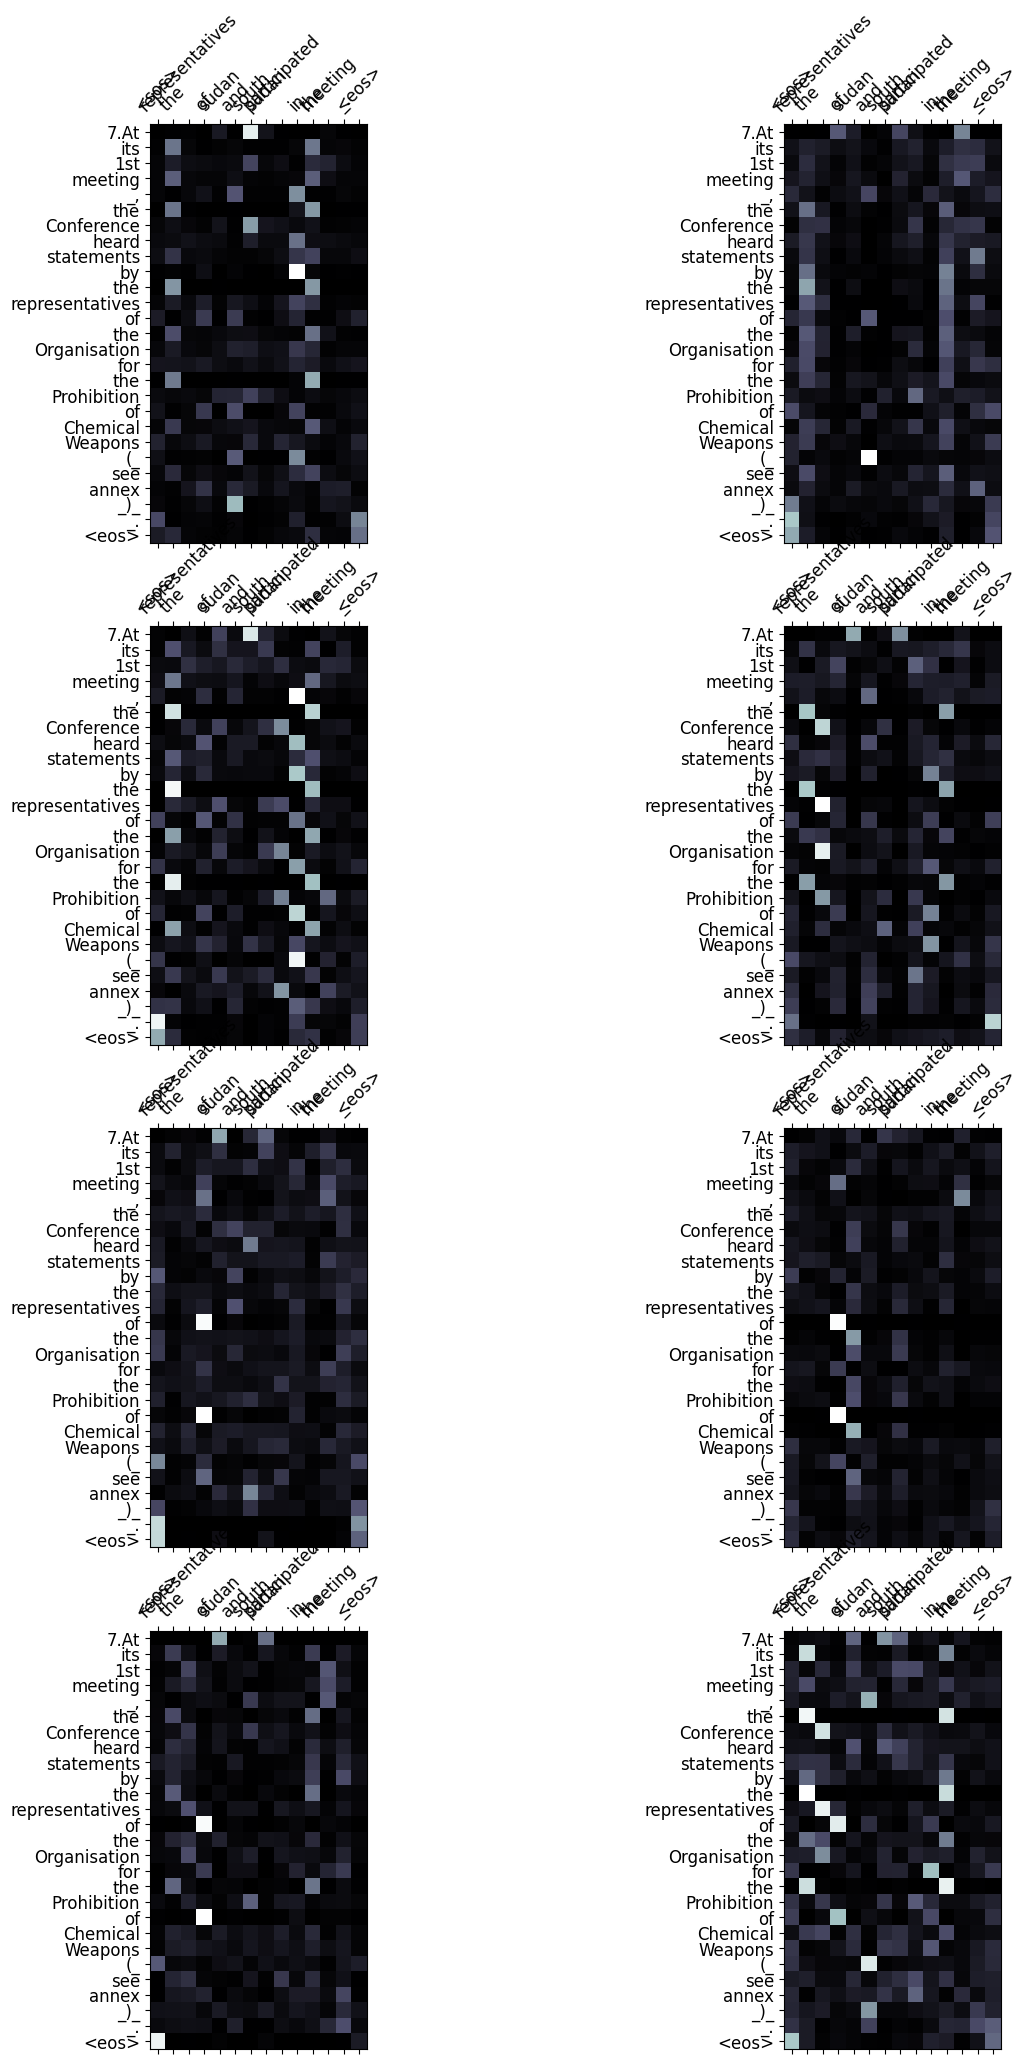

In [ ]:
display_attention(src, translation, attention)

In [ ]:
import torchtext
from code_utils.general import *

SRC = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tok,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

dataset0=torchtext.data.TabularDataset("test_bitext.tsv", "tsv", fields = (SRC, TRG), skip_header=True, csv_reader_params={})


TypeError: ignored

In [ ]:
#https://stackoverflow.com/questions/53046583/how-to-create-a-torchtext-data-tabulardataset-directly-from-a-list-or-dict
import torchtext
class TabularDataset_From_List(torchtext.data.Dataset):

    def __init__(self, input_list, format, fields, skip_header=False, **kwargs):
        make_example = {
            'json': Example.fromJSON, 'dict': Example.fromdict,
            'tsv': Example.fromTSV, 'csv': Example.fromCSV}[format.lower()]

        examples = [make_example(item, fields) for item in input_list]

        if make_example in (Example.fromdict, Example.fromJSON):
            fields, field_dict = [], fields
            for field in field_dict.values():
                if isinstance(field, list):
                    fields.extend(field)
                else:
                    fields.append(field)

        super(TabularDataset_From_List, self).__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, path=None, root='.data', train=None, validation=None,
               test=None, **kwargs):
        if path is None:
            path = cls.download(root)
        train_data = None if train is None else cls(
            train, **kwargs)
        val_data = None if validation is None else cls(
            validation, **kwargs)
        test_data = None if test is None else cls(
            test, **kwargs)
        return tuple(d for d in (train_data, val_data, test_data)
                     if d is not None)

obj0=TabularDataset_From_List()

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
     batch_size = BATCH_SIZE,
     device = device)

AttributeError: ignored

In [ ]:
#https://github.com/jadore801120/attention-is-all-you-need-pytorch
!rm -rf attention_mt
#!git clone https://github.com/jadore801120/attention-is-all-you-need-pytorch attention_mt
!git clone https://github.com/hmghaly/attention-is-all-you-need-pytorch.git attention_mt


Cloning into 'attention_mt'...
remote: Enumerating objects: 753, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 753 (delta 2), reused 0 (delta 0), pack-reused 747
Receiving objects: 100% (753/753), 170.15 KiB | 1.62 MiB/s, done.
Resolving deltas: 100% (493/493), done.


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-06-07 19:36:15.512036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 19:36:16.612112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-06-07 19:36:28.984037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the

In [ ]:
!pip install dill
!pip install torchtext==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.4.0
    Uninstalling torchtext-0.4.0:
      Successfully uninstalled torchtext-0.4.0


###Test on custom tabular data

In [ ]:
from torchtext.data import Field, BucketIterator
import torchtext

SRC = Field()
TRG = Field()
fields = {'src': ('src', SRC), 'trg': ('trg', TRG)}
train_data, test_data = torchtext.data.TabularDataset.splits(
                            path = 'test_files',
                            train = 'src_trg_train.json',
                            test = 'src_trg_train.json',
                            format = 'json',
                            fields = fields
)



In [ ]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator


NAME = Field()
SAYING = Field()
PLACE = Field()

In [ ]:
import torchtext
fields = {'name': ('n', NAME), 'location': ('p', PLACE), 'quote': ('s', SAYING)}
train_data, test_data = torchtext.data.TabularDataset.splits(
                            path = 'test_files',
                            train = 'train.json',
                            test = 'train.json',
                            format = 'json',
                            fields = fields
)

In [ ]:
a=train_data.examples[0]
a.n

['John']

In [ ]:
a=train_data.examples[0]
a.src

['an', 'english', 'sentence']

In [ ]:
os.chdir("attention_mt")
!python preprocess.py -lang_src de -lang_trg en -share_vocab -save_data m30k_deen_shr.pkl
os.chdir(cwd)

2023-06-07 19:36:53.277800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 19:36:54.385958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Namespace(lang_src='de', lang_trg='en', save_data='m30k_deen_shr.pkl', data_src=None, data_trg=None, max_len=100, min_word_count=3, keep_case=False, share_vocab=True)
Traceback (most recent call last):
  File "/content/drive/MyDrive/AI_UN/attention_mt/preprocess.py", line 336, in <module>
    main_wo_bpe()
  File "/content/drive/MyDrive/AI_UN/attention_mt/preprocess.py", line 271, in main_wo_bpe
    src_lang_model = spacy.load(spacy_src_lang_model_path)
  File "/usr/local/lib/python3.10/dist-packages/spacy/__init__.py", line 54, in load
    return util.load_

In [ ]:
import spacy
spacy.load('de_core_news_sm')

In [ ]:
spacy.load('en_core_web_sm')

In [ ]:
!!pip install torchtext==0.4

['Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/',
 'Requirement already satisfied: torchtext==0.4 in /usr/local/lib/python3.10/dist-packages (0.4.0)',
 'Requirement already satisfied: tqdm in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (4.65.0)',
 'Requirement already satisfied: requests in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (2.27.1)',
 'Requirement already satisfied: torch in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (2.0.1+cu118)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (1.22.4)',
 'Requirement already satisfied: six in /usr/local/lib/python3.10/dist-packages (from torchtext==0.4) (1.16.0)',
 'Requirement already satisfied: urllib3<1.27,>=1.21.1 in /usr/local/lib/python3.10/dist-packages (from requests->torchtext==0.4) (1.26.15)',
 'Requirement already satisfied: certifi>=2017.4.17 in /usr/local/lib/pyth

In [ ]:
!pip install -U torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchtext.data

In [ ]:
import torchtext.datasets as datasets

In [ ]:
datasets.

In [ ]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

ModuleNotFoundError: ignored

##Apply pretrained transformers

In [ ]:
#Happy transformer: https://huggingface.co/vennify/t5-base-grammar-correction
!pip install happytransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
from happytransformer import HappyTextToText, TTSettings

happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")

args = TTSettings(num_beams=5, min_length=1)

# Add the prefix "grammar: " before each input
result = happy_tt.generate_text("grammar: This sentences has has bads grammar.", args=args)

print(result.text) # This sentence has bad grammar.


This sentence has bad grammar.


In [ ]:
#sent0="grammar: This sentences has has bads grammar."
sent0="What would your do"
sent0="This Program show many colors"
#sent0="the walking group had some reservations"
sent0="the workings group had some reservations"
result = happy_tt.generate_text(sent0, args=args)
print(result.text) # This sentence has bad grammar.


The working group had some reservations, and the working group had some reservations.


In [ ]:
sent0="grammar: This sentences has has bads grammar."
result = happy_tt.generate_text(sent0, args=args)
print(result.text)


This sentence has bad grammar.


In [ ]:
sent0="the walking group had some reservations"
result = happy_tt.generate_text(sent0, args=args)
print(result.text)

The walking group had some reservations, and the walking group had some reservations.


In [ ]:
#sent0="the walking group had some reservations"
#The walking group had some reservations, and the walking group had some reservations.


In [ ]:
!pip install gingerit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00


In [ ]:
from gingerit.gingerit import GingerIt
sent0="grammar: This sentences has has bads grammar."
parser = GingerIt()
parse_out=parser.parse(sent0)
result0=parse_out["result"]
print("Original:",sent0)
print("Result:",result0)

Original: grammar: This sentences has has bads grammar.
Result: Grammar: This sentence has bad grammar.


In [ ]:
sent0 = 'The smelt of fliwers bring back memories.'

#OLD

In [ ]:
!pwd
!ls

/content/drive/MyDrive/AI_UN
 2015				    GAresolutions
 2021				    machine_readable_table_template.html
 2022				    mrdoc-initial.html
 2023				    ods-subject-list.xlsx
 2308011E_Editing.docx2		    OLD
 2308011E_Editing.zip		    Planning.gsheet
'AI Contact List - emails.gsheet'   pre-editing_table_template.html
'AI Strategy.gdoc'		    pre-edit-initial.html
 cat-mt.ipynb			   'Tentative Use Case Descriptions.gdoc'
 code_utils			    test_files
 data				   'Use Case Description - Full.gdoc'


In [ ]:
!cp 2023/Files/2308011E/2308011E_Editing.docx 2308011E_Editing.docx

In [ ]:
!ls /content/drive/MyDrive/AI_UN

 2015				    GAresolutions
 2021				    machine_readable_table_template.html
 2022				    mrdoc-initial.html
 2023				    ods-subject-list.xlsx
 2308011E_Editing.docx2		    OLD
 2308011E_Editing.zip		    Planning.gsheet
'AI Contact List - emails.gsheet'   pre-editing_table_template.html
'AI Strategy.gdoc'		    pre-edit-initial.html
 cat-mt.ipynb			   'Tentative Use Case Descriptions.gdoc'
 code_utils			    test_files
 data				   'Use Case Description - Full.gdoc'


In [ ]:
import shutil
root_dir=os.path.join(cwd,"Work-NLP")

fname="charts.pptx"
fname_copy="copy_"+fname
zip_fname=fname_copy.replace(".pptx",".zip")
unzip_dir=os.path.join(root_dir,fname.split(".")[0])
fpath=os.path.join(root_dir,fname)
fpath_copy=os.path.join(root_dir,fname_copy)
fpath_zip=os.path.join(root_dir,zip_fname)
shutil.copy(fpath,fpath_copy)
os.rename(fpath_copy,fpath_zip)

import zipfile
with zipfile.ZipFile(fpath_zip, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


In [ ]:
import re
terms_fpath=os.path.join(root_dir,"org-charts-terms.tsv")
terms_fopen=open(terms_fpath)
repl_dict={}
for i,f in enumerate(terms_fopen):
  if i==0: continue
  f_split=f.strip("\n\r\t").split("\t")
  if len(f_split)!=2: continue
  en,ar=f_split
  if en==ar: continue
  repl_dict[en]=ar
  #print(f_split)
terms_fopen.close()


slides_dir=os.path.join(unzip_dir,"ppt","slides")
for slide_fname in os.listdir(slides_dir):
  if not slide_fname.endswith(".xml"): continue
  slide_fpath=os.path.join(slides_dir,slide_fname)
  print(slide_fpath)
  slide_fopen=open(slide_fpath)
  slide_content=slide_fopen.read()
  slide_fopen.close()
  segs=re.findall(r"<a:t\b.*?>.*?</a:t>",slide_content)
  for original_seg in segs:

    cur_seg=str(original_seg)
    print(original_seg)
    if re.findall(">\(\d+ posts?\)",cur_seg):
      num=re.findall("\d+",cur_seg)[0]
      if int(num)==1:
        cur_seg="<a:t>"+num+ " وظيفة "+"</a:t>"
      elif int(num)>10:
        cur_seg="<a:t>"+num+ " وظيفة "+"</a:t>"
      else:
        cur_seg="<a:t>"+num+ " وظائف "+"</a:t>"

    else:
      cur_seg=cur_seg.replace(",","،")
      for r_en,r_ar in repl_dict.items():
        cur_seg=cur_seg.replace(r_en," "+ r_ar+" ")
      cur_seg=re.sub("\s+"," ",cur_seg)
    print(cur_seg)
    print("------")
    slide_content=slide_content.replace(original_seg,cur_seg)

  slide_fopen=open(slide_fpath,"w")
  slide_fopen.write(slide_content)
  #slide_content=slide_fopen.read()
  slide_fopen.close()

  #w_p_exp=r"<w:p\b.*?>.*?</w:p>"
  #<a:t>
import shutil
output_fname0="translated_charts"
output_fpath0=os.path.join(root_dir,output_fname0)
output_fpath_zip=os.path.join(output_fpath0+".zip")
output_fpath_pptx=os.path.join(output_fpath0+".pptx")
shutil.make_archive(output_fpath0, 'zip', unzip_dir)
os.rename(output_fpath_zip,output_fpath_pptx)

/content/drive/MyDrive/Work-NLP/charts/ppt/slides/slide1.xml
<a:t>Office of the Chief of Staff</a:t>
<a:t> مكتب رئيس الأركان </a:t>
------
<a:t>(13 posts)</a:t>
<a:t>13 وظيفة </a:t>
------
<a:t>1 D-2, 1 P-5, 1 P-4, 3 P-3, 2 P-2,</a:t>
<a:t>1 مد-2 ، 1 ف-5 ، 1 ف-4 ، 3 ف-3 ، 2 ف-2 ،</a:t>
------
<a:t>1 FS, 1 NPO, 3 NGS</a:t>
<a:t>1 خ م ، 1 م ف و ، 3 خ ع و </a:t>
------
<a:t>Joint Mission Analysis Centre</a:t>
<a:t> خلية التحليل المشتركة للبعثة </a:t>
------
<a:t>(7 posts)</a:t>
<a:t>7 وظائف </a:t>
------
<a:t>1 P-5, 2 P-4, 2 P-3, 2 NPO</a:t>
<a:t>1 ف-5 ، 2 ف-4 ، 2 ف-3 ، 2 م ف و </a:t>
------
<a:t>Conduct and Discipline Team</a:t>
<a:t> فريق السلوك والانضباط </a:t>
------
<a:t>(11 posts)</a:t>
<a:t>11 وظيفة </a:t>
------
<a:t>1 P-5, 1 P-4, 4 P-3, 1 FS, </a:t>
<a:t>1 ف-5 ، 1 ف-4 ، 4 ف-3 ، 1 خ م ، </a:t>
------
<a:t>3 NPO, 1 NGS</a:t>
<a:t>3 م ف و ، 1 خ ع و </a:t>
------
<a:t>Communications and Public</a:t>
<a:t>Communications and Public</a:t>
------
<a:t>Information Section </a:t>
<a:t>Info

In [ ]:
import hashlib
sha = hashlib.sha256()
sha.update('somestring'.encode())
sha.hexdigest()

def simple_hash(input_str,size=6):
  input_str=input_str.encode('utf-8')
  return hashlib.md5(input_str).hexdigest()[:size]

simple_hash("/content/drive/MyDrive/Work-NLP/charts/ppt/slides/slide1.xml",10)

'2c847cf6d9'